In [22]:

import os
import sys
import time
import torch
import numpy as np
import pandas as pd
import esm
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset

sys.path.append("../..")
from balm import common_utils
from balm.models.utils import load_trained_model
from balm.configs import Configs
from balm.models import BALM
from balm.metrics import get_ci, get_pearson, get_rmse, get_spearman



In [23]:
if torch.cuda.is_available():
    DEVICE = "cuda" 
else:
     DEVICE = 'cpu'

In [24]:
DEVICE

'cuda'

In [25]:
seed = 42
torch.cuda.manual_seed(seed)

In [26]:
# Define save and load checkpoint functions
def save_checkpoint(model, optimizer, epoch, file_path):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'peft_config': model.model_configs.peft_configs if hasattr(model.model_configs, 'peft_configs') else None

    }
    torch.save(checkpoint, file_path)
    print(f"Checkpoint saved at epoch {epoch} to {file_path}")

def load_checkpoint(model, optimizer,file_path):
    checkpoint = torch.load(file_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Checkpoint loaded from {file_path}, resuming from epoch {start_epoch}")
    return start_epoch

# Load Pretrained BALM

In [27]:
# Load config and model for zero-shot
config_filepath = "../../default_configs/balm_peft.yaml"
configs = Configs(**common_utils.load_yaml(config_filepath))

# Custom Dummy Data

Alternative to loading the data from a HF repo, you can also bring in your own custom data.

In [28]:
df = pd.read_csv(r"D:\BALM Fineclone\BALM-PPI\scripts\notebooks\Data.csv")
df


,proteina,Target,Y,Unnamed: 0,pdb_id,Unnamed: 5,Unnamed: 6,Unnamed: 7,source
0,DIQMTQSPSSLSASVGDRVTITCRTSQSISSYLNWYQQKPGKAPKL...,DQQSAFYEILNMPNLNEAQRNGFIQSLKDDPSQSTNVLGEAKKLNE...,6.397940,4465,1DEE,NaN,NaN,NaN,PDBbind v2020
1,VTVDTVCKRGFLIQMSGHLECKCENDLVLVNEETCEEKVLKCDEKT...,DVVMTQSPLSLPVTLGQPASISCRSSQSLVYSDGNTYLSWFQQRPG...,7.508638,4467,6B0G,NaN,NaN,NaN,PDBbind v2020
2,GDTICIGYHANNSTDTVDTVLEKNVTVTHSVNLLEDSHNGKLCKLK...,PWKFSENIAFEIALSFTNKDTPDRWKKVAQYVKGRTPEEVKKHYE,9.221849,4466,4EEF,NaN,NaN,NaN,PDBbind v2020
3,FTKELDQWIEQLNECKQLSESQVKSLCEKAKEILTKECGDGQFHDL...,AAEDELQLPRLPELFETGRQLLDEVEVATEPAGSRIVQEKVFKGLD...,6.522879,3071,4IYP,NaN,NaN,NaN,PDBbind v2020
4,MQTIKCVVVGDGAVGKTCLLISYTTNKFPSEYVPTVFDNYAVTVMI...,AAGELEERFNRALNCMNLPPDKVQLLSQYDNEKKWELICDQERFQV...,5.593460,3402,4YDH,NaN,NaN,NaN,PDBbind v2020
...,...,...,...,...,...,...,...,...,...
11071,GSVEKLTADAELQRLKNERHEEAELERLKSEY,YVEFSEECMHGSGENYDGKISKTMSGLECQAWDSQSPHAHGYIPSK...,7.187087,1918,2KJ4,NaN,NaN,NaN,PDBbind v2020
11072,NIVLTQSPASLAVSLGQRATISCRASESVDHYGNSFIYWYQQKPGQ...,YVMCTGSFKLEKEVAETQHGTVLVQVKYEGTDAPCKIPFSSQDEKG...,6.380907,1177,4FFZ,NaN,NaN,NaN,SAbDab
11073,QVQLLQPGAELVKPGASMKLSCKASGYTFTNWWMHWVRLRPGRGLE...,YVMCTGSFKLEKEVAETQHGTVLVQVKYEGTDAPCKIPFSSQDEKG...,6.380907,1215,4FFZ,NaN,NaN,NaN,SAbDab
11074,KLLEQSGAELVKPGASVRLSCTASGFNIKDTYMSWVKQRPEQGLEW...,YVMCTGSFKLEKEVAETQHGTVLVQVKYEGTDAPCKIPFSTQDEKG...,10.086186,2698,3UZQ,NaN,NaN,NaN,PDBbind v2020


In [29]:

# Calculate bounds
data_min = df['Y'].min()
data_max = df['Y'].max()
print(f"Data range: {data_min:.4f} to {data_max:.4f}")

Data range: 1.3188 to 15.6990


# Few shot training

Note: This is a simplified training process, for a more tested approach, please refer to our `balm/trainer.py`

In [30]:
# Few shot training
from sklearn.model_selection import train_test_split

# Split data
train_data, test_data = train_test_split(df, train_size=0.2, random_state=1234)
print(f"Number of train data: {len(train_data)}")
print(f"Number of test data: {len(test_data)}")

Number of train data: 2215
Number of test data: 8861


In [31]:
# Calculate bounds from the dataset
pkd_lower_bound = df['Y'].min()  # or set it to the value you prefer
pkd_upper_bound = df['Y'].max()  # or set it to the value you prefer

print(f"pkd_lower_bound: {pkd_lower_bound}, pkd_upper_bound: {pkd_upper_bound}")


pkd_lower_bound: 1.318758763, pkd_upper_bound: 15.69897


In [32]:
'''
#commenting this because I am normalizing below directly in traing and testing
# Define a function that applies the cosine similarity conversion to a single example
# This is VERY IMPORTANT since BALM uses cosine similarity
def add_cosine_similarity(example, pkd_upper_bound, pkd_lower_bound):
    example['cosine_similarity'] = (
        
        (example['Y'] - pkd_lower_bound) / (pkd_upper_bound - pkd_lower_bound)* 2 - 1
    )
    return example

# Use map to apply the function across the entire dataset
train_data = train_data.apply(lambda x: add_cosine_similarity(x, pkd_upper_bound, pkd_lower_bound), axis=1)
test_data = test_data.apply(lambda x: add_cosine_similarity(x, pkd_upper_bound, pkd_lower_bound), axis=1)
'''

"\n#commenting this because I am normalizing below directly in traing and testing\n# Define a function that applies the cosine similarity conversion to a single example\n# This is VERY IMPORTANT since BALM uses cosine similarity\ndef add_cosine_similarity(example, pkd_upper_bound, pkd_lower_bound):\n    example['cosine_similarity'] = (\n        \n        (example['Y'] - pkd_lower_bound) / (pkd_upper_bound - pkd_lower_bound)* 2 - 1\n    )\n    return example\n\n# Use map to apply the function across the entire dataset\ntrain_data = train_data.apply(lambda x: add_cosine_similarity(x, pkd_upper_bound, pkd_lower_bound), axis=1)\ntest_data = test_data.apply(lambda x: add_cosine_similarity(x, pkd_upper_bound, pkd_lower_bound), axis=1)\n"

In [33]:
# Initialize model for training
model = BALM(configs.model_configs)
model = model.to(DEVICE)

In [34]:
import wandb
from torch.optim import AdamW
from tqdm import tqdm
import time


wandb.login(key='60f195a60e62087702e68096c0e54f04406555dc')
# Initialize wandb
wandb.init(project='ppiATTPFT_local_test', entity='hs494-shiv-nadar-university')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [35]:

# Training loop
NUM_EPOCHS = 20
optimizer = torch.optim.AdamW(
    params=[param for name, param in model.named_parameters()],
    lr=configs.model_configs.model_hyperparameters.learning_rate,
)

print(f"Starting training with learning rate: {optimizer.param_groups[0]['lr']}")
print(f"Training on device: {DEVICE}")
print(f"Total training samples: {len(train_data)}")

Starting training with learning rate: 0.001
Training on device: cuda
Total training samples: 2215


In [36]:

#with normalization
# Log hyperparameters
wandb.config.learning_rate = configs.model_configs.model_hyperparameters.learning_rate
wandb.config.num_epochs = NUM_EPOCHS

# Load checkpoint if exists
checkpoint_path = r"D:\BALM Fineclone\BALM-PPI\scripts\notebooks\latest_checkpointcuratedmainATTPFT.pth"
start_epoch = 0
if os.path.exists(checkpoint_path):
    start_epoch = load_checkpoint(model,optimizer,checkpoint_path)
    

C:\Users\hs494\AppData\Local\Temp\ipykernel_21052\126795426.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_path)


Checkpoint loaded from D:\BALM Fineclone\BALM-PPI\scripts\notebooks\latest_checkpointcuratedmainATTPFT.pth, resuming from epoch 199


In [37]:

#with normalization
# Adjust NUM_EPOCHS to include the epochs already completed
NUM_EPOCHS += start_epoch

start = time.time()
best_loss = float('inf')

for epoch in range(start_epoch,NUM_EPOCHS):
    model.train()
    total_loss = 0.0
    
    # Create progress bar for each epoch
    pbar = tqdm(train_data.iterrows(), total=len(train_data), 
                desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", leave=False)
    
    batch_losses = []  # Track individual batch losses
    
    for idx, sample in pbar:
        # Scale to cosine similarity range
        cosine_target = 2 * (sample['Y'] - data_min) / (data_max - data_min) - 1
        
        inputs = {
            "protein_sequences": [sample["Target"]],
            "proteina_sequences": [sample["proteina"]],
            "labels": torch.tensor([cosine_target], dtype=torch.float32).to(DEVICE)
        }

        # Print sequence lengths occasionally
        if idx % 100 == 0:
            print(f"\nSequence lengths - Target: {len(sample['Target'])}, "
                  f"ProteinA: {len(sample['proteina'])}")

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = outputs["loss"]
        loss.backward()
        
        # Gradient norm debugging
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        if idx % 100 == 0:
            print(f"Gradient norm: {grad_norm:.4f}")

        optimizer.step()
        
        current_loss = loss.item()
        batch_losses.append(current_loss)
        total_loss += current_loss
        
        # Update progress bar with current loss
        pbar.set_postfix({
            'batch_loss': f'{current_loss:.4f}',
            'avg_loss': f'{total_loss/(idx+1):.4f}'
        })

    avg_loss = total_loss / len(train_data)
    
    # Print detailed epoch summary
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}] Summary:")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Min Batch Loss: {min(batch_losses):.4f}")
    print(f"Max Batch Loss: {max(batch_losses):.4f}")
    
    # Track best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        print(f"New best loss achieved! Previous best: {best_loss:.4f}")

    # Print memory usage if using CUDA
    if torch.cuda.is_available():
        print(f"GPU Memory allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")
        print(f"GPU Memory cached: {torch.cuda.memory_reserved()/1e9:.2f} GB")
    
    # Log metrics to wandb
    wandb.log({'epoch': epoch + 1, 'loss': avg_loss})
    
    # Save checkpoint after each epoch
    save_checkpoint(model, optimizer, epoch+1, checkpoint_path)

training_time = time.time() - start
print("\nTraining complete!")
print(f"Total training time: {training_time/60:.2f} minutes")
print(f"Average time per epoch: {training_time/NUM_EPOCHS/60:.2f} minutes")
print(f"Best loss achieved: {best_loss:.4f}")


Epoch 200/219:   1%|          | 16/2215 [00:02<05:31,  6.63it/s, batch_loss=0.0033, avg_loss=0.0000]


Sequence lengths - Target: 1180, ProteinA: 940


Epoch 200/219:   1%|          | 18/2215 [00:02<08:10,  4.48it/s, batch_loss=0.0115, avg_loss=0.0001]

Gradient norm: 0.0441


Epoch 200/219:  24%|██▍       | 534/2215 [01:17<03:40,  7.64it/s, batch_loss=0.0247, avg_loss=0.0016]


Sequence lengths - Target: 129, ProteinA: 432
Gradient norm: 0.0593


Epoch 200/219:  27%|██▋       | 593/2215 [01:27<04:16,  6.32it/s, batch_loss=0.0131, avg_loss=0.0013]


Sequence lengths - Target: 174, ProteinA: 597


Epoch 200/219:  27%|██▋       | 595/2215 [01:27<04:15,  6.35it/s, batch_loss=0.0002, avg_loss=0.0020]

Gradient norm: 0.0741


Epoch 200/219:  35%|███▌      | 785/2215 [01:56<03:31,  6.76it/s, batch_loss=0.0014, avg_loss=0.0039]


Sequence lengths - Target: 475, ProteinA: 1288


Epoch 200/219:  36%|███▌      | 787/2215 [01:57<04:53,  4.86it/s, batch_loss=0.0020, avg_loss=0.0013]

Gradient norm: 0.0002


Epoch 200/219:  37%|███▋      | 827/2215 [02:03<03:59,  5.80it/s, batch_loss=0.0001, avg_loss=0.0011]


Sequence lengths - Target: 347, ProteinA: 432
Gradient norm: 0.0041


Epoch 200/219:  38%|███▊      | 836/2215 [02:04<03:05,  7.43it/s, batch_loss=0.0009, avg_loss=0.0019]


Sequence lengths - Target: 167, ProteinA: 87
Gradient norm: 0.0172


Epoch 200/219:  42%|████▏     | 938/2215 [02:20<02:52,  7.40it/s, batch_loss=0.0646, avg_loss=0.0447]


Sequence lengths - Target: 165, ProteinA: 262
Gradient norm: 0.0856


Epoch 200/219:  44%|████▍     | 977/2215 [02:26<03:40,  5.62it/s, batch_loss=0.0010, avg_loss=0.0017]


Sequence lengths - Target: 223, ProteinA: 187
Gradient norm: 0.0250


Epoch 200/219:  51%|█████▏    | 1138/2215 [02:50<03:00,  5.96it/s, batch_loss=0.0005, avg_loss=0.0036]


Sequence lengths - Target: 129, ProteinA: 429
Gradient norm: 0.0082


Epoch 200/219:  55%|█████▌    | 1227/2215 [03:04<02:07,  7.76it/s, batch_loss=0.0168, avg_loss=0.0036]


Sequence lengths - Target: 436, ProteinA: 386


Epoch 200/219:  55%|█████▌    | 1229/2215 [03:04<02:16,  7.25it/s, batch_loss=0.0633, avg_loss=0.0022]

Gradient norm: 0.0038


Epoch 200/219:  56%|█████▋    | 1248/2215 [03:07<02:09,  7.49it/s, batch_loss=0.0000, avg_loss=0.0017]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.0070


Epoch 200/219:  60%|██████    | 1331/2215 [03:22<02:01,  7.28it/s, batch_loss=0.0111, avg_loss=0.0018]


Sequence lengths - Target: 126, ProteinA: 455
Gradient norm: 0.1844


Epoch 200/219:  68%|██████▊   | 1511/2215 [03:50<01:38,  7.17it/s, batch_loss=0.0079, avg_loss=0.0042]


Sequence lengths - Target: 56, ProteinA: 218
Gradient norm: 0.1882


Epoch 200/219:  70%|██████▉   | 1545/2215 [03:55<01:32,  7.28it/s, batch_loss=0.0000, avg_loss=0.0098]


Sequence lengths - Target: 338, ProteinA: 317
Gradient norm: 0.0064


Epoch 200/219:  71%|███████▏  | 1582/2215 [04:01<01:35,  6.62it/s, batch_loss=0.0025, avg_loss=0.0033]


Sequence lengths - Target: 489, ProteinA: 30
Gradient norm: 0.0532


Epoch 200/219:  73%|███████▎  | 1612/2215 [04:05<01:29,  6.72it/s, batch_loss=0.0393, avg_loss=0.0098]


Sequence lengths - Target: 126, ProteinA: 460
Gradient norm: 0.1377


Epoch 200/219:  73%|███████▎  | 1620/2215 [04:06<01:34,  6.33it/s, batch_loss=0.0007, avg_loss=0.0073]


Sequence lengths - Target: 356, ProteinA: 122
Gradient norm: 0.0160


Epoch 200/219:  76%|███████▌  | 1688/2215 [04:16<01:12,  7.29it/s, batch_loss=0.0057, avg_loss=0.0025]


Sequence lengths - Target: 61, ProteinA: 533
Gradient norm: 0.1066


Epoch 200/219:  78%|███████▊  | 1717/2215 [04:21<01:12,  6.86it/s, batch_loss=0.0001, avg_loss=0.0022]


Sequence lengths - Target: 67, ProteinA: 104
Gradient norm: 0.0118


Epoch 200/219:  84%|████████▍ | 1869/2215 [04:45<01:11,  4.87it/s, batch_loss=0.0001, avg_loss=0.0031]


Sequence lengths - Target: 72, ProteinA: 118
Gradient norm: 0.0079


Epoch 200/219:  93%|█████████▎| 2050/2215 [05:11<00:21,  7.83it/s, batch_loss=0.0008, avg_loss=0.0028]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.0202


Epoch 200/219:  98%|█████████▊| 2161/2215 [05:26<00:06,  8.04it/s, batch_loss=0.0036, avg_loss=0.0034]


Sequence lengths - Target: 266, ProteinA: 165
Gradient norm: 0.1184



Epoch [200/219] Summary:
Average Loss: 0.0147
Min Batch Loss: 0.0000
Max Batch Loss: 0.5134
New best loss achieved! Previous best: 0.0147
GPU Memory allocated: 5.41 GB
GPU Memory cached: 15.56 GB
Checkpoint saved at epoch 200 to D:\BALM Fineclone\BALM-PPI\scripts\notebooks\latest_checkpointcuratedmainATTPFT.pth


Epoch 201/219:   1%|          | 16/2215 [00:02<05:34,  6.58it/s, batch_loss=0.0119, avg_loss=0.0000]


Sequence lengths - Target: 1180, ProteinA: 940


Epoch 201/219:   1%|          | 18/2215 [00:03<08:15,  4.44it/s, batch_loss=0.0055, avg_loss=0.0001]

Gradient norm: 0.0308


Epoch 201/219:  24%|██▍       | 534/2215 [01:20<03:43,  7.51it/s, batch_loss=0.0347, avg_loss=0.0016]


Sequence lengths - Target: 129, ProteinA: 432
Gradient norm: 0.0800


Epoch 201/219:  27%|██▋       | 593/2215 [01:30<04:28,  6.04it/s, batch_loss=0.0023, avg_loss=0.0092]


Sequence lengths - Target: 174, ProteinA: 597
Gradient norm: 0.0508


Epoch 201/219:  35%|███▌      | 785/2215 [01:57<03:11,  7.46it/s, batch_loss=0.0053, avg_loss=0.0038]


Sequence lengths - Target: 475, ProteinA: 1288


Epoch 201/219:  35%|███▌      | 786/2215 [01:58<04:56,  4.81it/s, batch_loss=0.0000, avg_loss=0.0013]

Gradient norm: 0.0155


Epoch 201/219:  37%|███▋      | 826/2215 [02:03<03:19,  6.97it/s, batch_loss=0.0000, avg_loss=0.0010]


Sequence lengths - Target: 347, ProteinA: 432
Gradient norm: 0.0007


Epoch 201/219:  38%|███▊      | 837/2215 [02:04<02:35,  8.84it/s, batch_loss=0.0092, avg_loss=0.1519]


Sequence lengths - Target: 167, ProteinA: 87
Gradient norm: 0.0170


Epoch 201/219:  42%|████▏     | 938/2215 [02:19<02:58,  7.16it/s, batch_loss=0.0759, avg_loss=0.0023]


Sequence lengths - Target: 165, ProteinA: 262
Gradient norm: 0.0818


Epoch 201/219:  44%|████▍     | 977/2215 [02:24<03:25,  6.02it/s, batch_loss=0.0012, avg_loss=0.0017]


Sequence lengths - Target: 223, ProteinA: 187
Gradient norm: 0.0331


Epoch 201/219:  51%|█████▏    | 1138/2215 [02:45<02:34,  6.96it/s, batch_loss=0.0004, avg_loss=0.0036]


Sequence lengths - Target: 129, ProteinA: 429
Gradient norm: 0.0089


Epoch 201/219:  55%|█████▌    | 1226/2215 [02:57<02:01,  8.17it/s, batch_loss=0.0063, avg_loss=0.0036]


Sequence lengths - Target: 436, ProteinA: 386


Epoch 201/219:  55%|█████▌    | 1229/2215 [02:58<02:01,  8.11it/s, batch_loss=0.0639, avg_loss=0.0022]

Gradient norm: 0.0179


Epoch 201/219:  56%|█████▋    | 1248/2215 [03:00<01:49,  8.84it/s, batch_loss=0.0112, avg_loss=0.0017]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.1421


Epoch 201/219:  60%|██████    | 1331/2215 [03:14<01:40,  8.77it/s, batch_loss=0.0000, avg_loss=0.0018]


Sequence lengths - Target: 126, ProteinA: 455
Gradient norm: 0.0009


Epoch 201/219:  68%|██████▊   | 1512/2215 [03:39<01:14,  9.44it/s, batch_loss=0.0049, avg_loss=0.0021]


Sequence lengths - Target: 56, ProteinA: 218
Gradient norm: 0.1722


Epoch 201/219:  70%|██████▉   | 1545/2215 [03:44<01:26,  7.78it/s, batch_loss=0.0004, avg_loss=0.0097]


Sequence lengths - Target: 338, ProteinA: 317
Gradient norm: 0.0209


Epoch 201/219:  71%|███████▏  | 1582/2215 [03:49<01:20,  7.83it/s, batch_loss=0.0004, avg_loss=0.0033]


Sequence lengths - Target: 489, ProteinA: 30
Gradient norm: 0.0238


Epoch 201/219:  73%|███████▎  | 1612/2215 [03:52<01:15,  8.02it/s, batch_loss=0.0338, avg_loss=0.0096]


Sequence lengths - Target: 126, ProteinA: 460
Gradient norm: 0.1419


Epoch 201/219:  73%|███████▎  | 1620/2215 [03:53<01:21,  7.34it/s, batch_loss=0.0000, avg_loss=0.0071]


Sequence lengths - Target: 356, ProteinA: 122
Gradient norm: 0.0026


Epoch 201/219:  76%|███████▋  | 1689/2215 [04:02<01:06,  7.91it/s, batch_loss=0.0019, avg_loss=0.0025]


Sequence lengths - Target: 61, ProteinA: 533
Gradient norm: 0.0338


Epoch 201/219:  78%|███████▊  | 1718/2215 [04:07<00:54,  9.08it/s, batch_loss=0.0014, avg_loss=0.0025]


Sequence lengths - Target: 67, ProteinA: 104
Gradient norm: 0.0364


Epoch 201/219:  84%|████████▍ | 1870/2215 [04:28<00:54,  6.30it/s, batch_loss=0.0015, avg_loss=0.0032]


Sequence lengths - Target: 72, ProteinA: 118
Gradient norm: 0.0272


Epoch 201/219:  93%|█████████▎| 2051/2215 [04:50<00:15, 10.56it/s, batch_loss=0.0004, avg_loss=0.0029]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.0141


Epoch 201/219:  98%|█████████▊| 2161/2215 [05:04<00:05,  9.06it/s, batch_loss=0.0006, avg_loss=0.0034]


Sequence lengths - Target: 266, ProteinA: 165
Gradient norm: 0.0237



Epoch [201/219] Summary:
Average Loss: 0.0144
Min Batch Loss: 0.0000
Max Batch Loss: 0.5073
New best loss achieved! Previous best: 0.0144
GPU Memory allocated: 5.41 GB
GPU Memory cached: 15.56 GB
Checkpoint saved at epoch 201 to D:\BALM Fineclone\BALM-PPI\scripts\notebooks\latest_checkpointcuratedmainATTPFT.pth


Epoch 202/219:   1%|          | 16/2215 [00:02<05:04,  7.23it/s, batch_loss=0.0001, avg_loss=0.0000]


Sequence lengths - Target: 1180, ProteinA: 940


Epoch 202/219:   1%|          | 17/2215 [00:03<09:37,  3.80it/s, batch_loss=0.0046, avg_loss=0.0000]

Gradient norm: 0.0481


Epoch 202/219:  24%|██▍       | 534/2215 [01:10<03:14,  8.65it/s, batch_loss=0.0370, avg_loss=0.0016]


Sequence lengths - Target: 129, ProteinA: 432
Gradient norm: 0.0881


Epoch 202/219:  27%|██▋       | 593/2215 [01:18<04:03,  6.65it/s, batch_loss=0.0039, avg_loss=0.0013]


Sequence lengths - Target: 174, ProteinA: 597
Gradient norm: 0.0218


Epoch 202/219:  35%|███▌      | 785/2215 [01:45<03:12,  7.44it/s, batch_loss=0.0013, avg_loss=0.0039]


Sequence lengths - Target: 475, ProteinA: 1288


Epoch 202/219:  35%|███▌      | 786/2215 [01:45<04:57,  4.80it/s, batch_loss=0.0107, avg_loss=0.0013]

Gradient norm: 0.0543


Epoch 202/219:  37%|███▋      | 826/2215 [01:51<03:19,  6.95it/s, batch_loss=0.0005, avg_loss=0.0010]


Sequence lengths - Target: 347, ProteinA: 432
Gradient norm: 0.0161


Epoch 202/219:  38%|███▊      | 837/2215 [01:52<02:32,  9.03it/s, batch_loss=0.0016, avg_loss=0.1537]


Sequence lengths - Target: 167, ProteinA: 87
Gradient norm: 0.0127


Epoch 202/219:  42%|████▏     | 938/2215 [02:07<02:58,  7.15it/s, batch_loss=0.0859, avg_loss=0.0024]


Sequence lengths - Target: 165, ProteinA: 262
Gradient norm: 0.0819


Epoch 202/219:  44%|████▍     | 977/2215 [02:11<03:24,  6.05it/s, batch_loss=0.0006, avg_loss=0.0017]


Sequence lengths - Target: 223, ProteinA: 187
Gradient norm: 0.0282


Epoch 202/219:  51%|█████▏    | 1138/2215 [02:33<02:34,  6.99it/s, batch_loss=0.0001, avg_loss=0.0037]


Sequence lengths - Target: 129, ProteinA: 429
Gradient norm: 0.0038


Epoch 202/219:  55%|█████▌    | 1226/2215 [02:45<02:01,  8.16it/s, batch_loss=0.0041, avg_loss=0.1777]


Sequence lengths - Target: 436, ProteinA: 386
Gradient norm: 0.0352


Epoch 202/219:  56%|█████▋    | 1248/2215 [02:48<01:48,  8.92it/s, batch_loss=0.0720, avg_loss=0.0017]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.7076


Epoch 202/219:  60%|██████    | 1331/2215 [03:01<01:43,  8.54it/s, batch_loss=0.0058, avg_loss=0.0018]


Sequence lengths - Target: 126, ProteinA: 455
Gradient norm: 0.0944


Epoch 202/219:  68%|██████▊   | 1512/2215 [03:27<01:14,  9.44it/s, batch_loss=0.0289, avg_loss=0.0021]


Sequence lengths - Target: 56, ProteinA: 218
Gradient norm: 0.1966


Epoch 202/219:  70%|██████▉   | 1545/2215 [03:31<01:26,  7.76it/s, batch_loss=0.0005, avg_loss=0.0099]


Sequence lengths - Target: 338, ProteinA: 317
Gradient norm: 0.0197


Epoch 202/219:  71%|███████▏  | 1582/2215 [03:36<01:20,  7.87it/s, batch_loss=0.0024, avg_loss=0.0033]


Sequence lengths - Target: 489, ProteinA: 30
Gradient norm: 0.0403


Epoch 202/219:  73%|███████▎  | 1612/2215 [03:40<01:16,  7.91it/s, batch_loss=0.0236, avg_loss=0.0098]


Sequence lengths - Target: 126, ProteinA: 460
Gradient norm: 0.1115


Epoch 202/219:  73%|███████▎  | 1620/2215 [03:41<01:21,  7.32it/s, batch_loss=0.0007, avg_loss=0.0073]


Sequence lengths - Target: 356, ProteinA: 122
Gradient norm: 0.0151


Epoch 202/219:  76%|███████▋  | 1689/2215 [03:50<01:06,  7.91it/s, batch_loss=0.0075, avg_loss=0.0025]


Sequence lengths - Target: 61, ProteinA: 533
Gradient norm: 0.0928


Epoch 202/219:  78%|███████▊  | 1718/2215 [03:54<00:53,  9.22it/s, batch_loss=0.0000, avg_loss=0.0026]


Sequence lengths - Target: 67, ProteinA: 104
Gradient norm: 0.0289


Epoch 202/219:  84%|████████▍ | 1870/2215 [04:16<00:54,  6.32it/s, batch_loss=0.0435, avg_loss=0.0032]


Sequence lengths - Target: 72, ProteinA: 118
Gradient norm: 0.0118


Epoch 202/219:  93%|█████████▎| 2051/2215 [04:38<00:15, 10.67it/s, batch_loss=0.0000, avg_loss=0.0029]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.0322


Epoch 202/219:  98%|█████████▊| 2161/2215 [04:51<00:05,  9.17it/s, batch_loss=0.0012, avg_loss=0.0034]


Sequence lengths - Target: 266, ProteinA: 165
Gradient norm: 0.0300



Epoch [202/219] Summary:
Average Loss: 0.0147
Min Batch Loss: 0.0000
Max Batch Loss: 0.5045
GPU Memory allocated: 5.41 GB
GPU Memory cached: 15.56 GB
Checkpoint saved at epoch 202 to D:\BALM Fineclone\BALM-PPI\scripts\notebooks\latest_checkpointcuratedmainATTPFT.pth


Epoch 203/219:   1%|          | 16/2215 [00:02<05:03,  7.25it/s, batch_loss=0.0023, avg_loss=0.0000]


Sequence lengths - Target: 1180, ProteinA: 940


Epoch 203/219:   1%|          | 17/2215 [00:03<09:36,  3.81it/s, batch_loss=0.0258, avg_loss=0.0001]

Gradient norm: 0.0331


Epoch 203/219:  24%|██▍       | 534/2215 [01:10<03:12,  8.75it/s, batch_loss=0.0213, avg_loss=0.0016]


Sequence lengths - Target: 129, ProteinA: 432
Gradient norm: 0.0619


Epoch 203/219:  27%|██▋       | 593/2215 [01:18<03:56,  6.87it/s, batch_loss=0.0007, avg_loss=0.0013]


Sequence lengths - Target: 174, ProteinA: 597
Gradient norm: 0.0260


Epoch 203/219:  35%|███▌      | 785/2215 [01:44<03:12,  7.42it/s, batch_loss=0.0011, avg_loss=0.0040]


Sequence lengths - Target: 475, ProteinA: 1288


Epoch 203/219:  35%|███▌      | 786/2215 [01:45<04:57,  4.81it/s, batch_loss=0.0086, avg_loss=0.0013]

Gradient norm: 0.0185


Epoch 203/219:  37%|███▋      | 827/2215 [01:50<03:31,  6.58it/s, batch_loss=0.0003, avg_loss=0.0011]


Sequence lengths - Target: 347, ProteinA: 432
Gradient norm: 0.0114


Epoch 203/219:  38%|███▊      | 837/2215 [01:52<02:35,  8.85it/s, batch_loss=0.0026, avg_loss=0.1569]


Sequence lengths - Target: 167, ProteinA: 87
Gradient norm: 0.0004


Epoch 203/219:  42%|████▏     | 938/2215 [02:06<02:55,  7.28it/s, batch_loss=0.0661, avg_loss=0.0450]


Sequence lengths - Target: 165, ProteinA: 262
Gradient norm: 0.0884


Epoch 203/219:  44%|████▍     | 977/2215 [02:11<03:24,  6.05it/s, batch_loss=0.0008, avg_loss=0.0017]


Sequence lengths - Target: 223, ProteinA: 187
Gradient norm: 0.0248


Epoch 203/219:  51%|█████▏    | 1138/2215 [02:33<02:34,  6.99it/s, batch_loss=0.0000, avg_loss=0.0037]


Sequence lengths - Target: 129, ProteinA: 429
Gradient norm: 0.0014


Epoch 203/219:  55%|█████▌    | 1226/2215 [02:45<02:03,  8.02it/s, batch_loss=0.0004, avg_loss=0.1806]


Sequence lengths - Target: 436, ProteinA: 386
Gradient norm: 0.0096


Epoch 203/219:  56%|█████▋    | 1248/2215 [02:47<01:48,  8.89it/s, batch_loss=0.0055, avg_loss=0.0018]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.0724


Epoch 203/219:  60%|██████    | 1331/2215 [03:01<01:42,  8.64it/s, batch_loss=0.0000, avg_loss=0.0018]


Sequence lengths - Target: 126, ProteinA: 455
Gradient norm: 0.0077


Epoch 203/219:  68%|██████▊   | 1512/2215 [03:26<01:14,  9.38it/s, batch_loss=0.0227, avg_loss=0.0021]


Sequence lengths - Target: 56, ProteinA: 218
Gradient norm: 0.0937


Epoch 203/219:  70%|██████▉   | 1545/2215 [03:31<01:26,  7.79it/s, batch_loss=0.0145, avg_loss=0.0100]


Sequence lengths - Target: 338, ProteinA: 317
Gradient norm: 0.1174


Epoch 203/219:  71%|███████▏  | 1582/2215 [03:36<01:20,  7.84it/s, batch_loss=0.0237, avg_loss=0.0034]


Sequence lengths - Target: 489, ProteinA: 30
Gradient norm: 0.0774


Epoch 203/219:  73%|███████▎  | 1612/2215 [03:39<01:15,  8.00it/s, batch_loss=0.0439, avg_loss=0.0100]


Sequence lengths - Target: 126, ProteinA: 460
Gradient norm: 0.1370


Epoch 203/219:  73%|███████▎  | 1620/2215 [03:40<01:21,  7.32it/s, batch_loss=0.0044, avg_loss=0.0074]


Sequence lengths - Target: 356, ProteinA: 122
Gradient norm: 0.0418


Epoch 203/219:  76%|███████▋  | 1689/2215 [03:49<01:06,  7.88it/s, batch_loss=0.0025, avg_loss=0.0025]


Sequence lengths - Target: 61, ProteinA: 533
Gradient norm: 0.0520


Epoch 203/219:  78%|███████▊  | 1718/2215 [03:54<00:54,  9.16it/s, batch_loss=0.0001, avg_loss=0.0026]


Sequence lengths - Target: 67, ProteinA: 104
Gradient norm: 0.0656


Epoch 203/219:  84%|████████▍ | 1870/2215 [04:15<00:54,  6.33it/s, batch_loss=0.0156, avg_loss=0.0032]


Sequence lengths - Target: 72, ProteinA: 118
Gradient norm: 0.0154


Epoch 203/219:  93%|█████████▎| 2051/2215 [04:37<00:15, 10.54it/s, batch_loss=0.0000, avg_loss=0.0029]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.0250


Epoch 203/219:  98%|█████████▊| 2161/2215 [04:51<00:05,  9.18it/s, batch_loss=0.0048, avg_loss=0.0034]


Sequence lengths - Target: 266, ProteinA: 165
Gradient norm: 0.0770



Epoch [203/219] Summary:
Average Loss: 0.0147
Min Batch Loss: 0.0000
Max Batch Loss: 0.4530
GPU Memory allocated: 5.41 GB
GPU Memory cached: 15.56 GB
Checkpoint saved at epoch 203 to D:\BALM Fineclone\BALM-PPI\scripts\notebooks\latest_checkpointcuratedmainATTPFT.pth


Epoch 204/219:   1%|          | 16/2215 [00:02<05:03,  7.24it/s, batch_loss=0.0002, avg_loss=0.0000]


Sequence lengths - Target: 1180, ProteinA: 940


Epoch 204/219:   1%|          | 17/2215 [00:03<09:35,  3.82it/s, batch_loss=0.0132, avg_loss=0.0001]

Gradient norm: 0.0397


Epoch 204/219:  24%|██▍       | 534/2215 [01:09<03:14,  8.66it/s, batch_loss=0.0469, avg_loss=0.0016]


Sequence lengths - Target: 129, ProteinA: 432
Gradient norm: 0.0940


Epoch 204/219:  27%|██▋       | 593/2215 [01:18<04:03,  6.67it/s, batch_loss=0.0036, avg_loss=0.0013]


Sequence lengths - Target: 174, ProteinA: 597
Gradient norm: 0.0798


Epoch 204/219:  35%|███▌      | 785/2215 [01:44<03:12,  7.41it/s, batch_loss=0.0004, avg_loss=0.0040]


Sequence lengths - Target: 475, ProteinA: 1288


Epoch 204/219:  35%|███▌      | 786/2215 [01:45<04:57,  4.80it/s, batch_loss=0.0000, avg_loss=0.0013]

Gradient norm: 0.0244


Epoch 204/219:  37%|███▋      | 826/2215 [01:50<03:19,  6.96it/s, batch_loss=0.0000, avg_loss=0.0011]


Sequence lengths - Target: 347, ProteinA: 432
Gradient norm: 0.0033


Epoch 204/219:  38%|███▊      | 837/2215 [01:52<02:38,  8.70it/s, batch_loss=0.0005, avg_loss=0.1562]


Sequence lengths - Target: 167, ProteinA: 87
Gradient norm: 0.0229


Epoch 204/219:  42%|████▏     | 938/2215 [02:06<02:55,  7.28it/s, batch_loss=0.0904, avg_loss=0.0025]


Sequence lengths - Target: 165, ProteinA: 262
Gradient norm: 0.0680


Epoch 204/219:  44%|████▍     | 977/2215 [02:11<03:24,  6.04it/s, batch_loss=0.0007, avg_loss=0.0018]


Sequence lengths - Target: 223, ProteinA: 187
Gradient norm: 0.0293


Epoch 204/219:  51%|█████▏    | 1138/2215 [02:33<02:34,  6.97it/s, batch_loss=0.0001, avg_loss=0.0038]


Sequence lengths - Target: 129, ProteinA: 429
Gradient norm: 0.0031


Epoch 204/219:  55%|█████▌    | 1226/2215 [02:45<01:59,  8.25it/s, batch_loss=0.0129, avg_loss=0.0037]


Sequence lengths - Target: 436, ProteinA: 386


Epoch 204/219:  55%|█████▌    | 1229/2215 [02:45<02:01,  8.09it/s, batch_loss=0.0643, avg_loss=0.0023]

Gradient norm: 0.0039


Epoch 204/219:  56%|█████▋    | 1248/2215 [02:47<01:48,  8.94it/s, batch_loss=0.0079, avg_loss=0.0018]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.2295


Epoch 204/219:  60%|██████    | 1331/2215 [03:01<01:42,  8.65it/s, batch_loss=0.0002, avg_loss=0.0019]


Sequence lengths - Target: 126, ProteinA: 455
Gradient norm: 0.0161


Epoch 204/219:  68%|██████▊   | 1512/2215 [03:26<01:16,  9.22it/s, batch_loss=0.0298, avg_loss=0.0021]


Sequence lengths - Target: 56, ProteinA: 218
Gradient norm: 0.0037


Epoch 204/219:  70%|██████▉   | 1545/2215 [03:31<01:26,  7.76it/s, batch_loss=0.0003, avg_loss=0.0100]


Sequence lengths - Target: 338, ProteinA: 317
Gradient norm: 0.0137


Epoch 204/219:  71%|███████▏  | 1582/2215 [03:36<01:21,  7.76it/s, batch_loss=0.0015, avg_loss=0.0034]


Sequence lengths - Target: 489, ProteinA: 30
Gradient norm: 0.0341


Epoch 204/219:  73%|███████▎  | 1612/2215 [03:39<01:15,  8.02it/s, batch_loss=0.0315, avg_loss=0.0099]


Sequence lengths - Target: 126, ProteinA: 460
Gradient norm: 0.1454


Epoch 204/219:  73%|███████▎  | 1620/2215 [03:41<01:20,  7.35it/s, batch_loss=0.0001, avg_loss=0.0074]


Sequence lengths - Target: 356, ProteinA: 122
Gradient norm: 0.0067


Epoch 204/219:  76%|███████▋  | 1689/2215 [03:50<01:06,  7.92it/s, batch_loss=0.0001, avg_loss=0.0025]


Sequence lengths - Target: 61, ProteinA: 533
Gradient norm: 0.0204


Epoch 204/219:  78%|███████▊  | 1718/2215 [03:54<00:53,  9.22it/s, batch_loss=0.0144, avg_loss=0.0026]


Sequence lengths - Target: 67, ProteinA: 104
Gradient norm: 0.0642


Epoch 204/219:  84%|████████▍ | 1870/2215 [04:15<00:54,  6.31it/s, batch_loss=0.0184, avg_loss=0.0033]


Sequence lengths - Target: 72, ProteinA: 118
Gradient norm: 0.0008


Epoch 204/219:  93%|█████████▎| 2051/2215 [04:38<00:15, 10.54it/s, batch_loss=0.0002, avg_loss=0.0029]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.0153


Epoch 204/219:  98%|█████████▊| 2161/2215 [04:51<00:05,  9.17it/s, batch_loss=0.0082, avg_loss=0.0034]


Sequence lengths - Target: 266, ProteinA: 165
Gradient norm: 0.0726



Epoch [204/219] Summary:
Average Loss: 0.0147
Min Batch Loss: 0.0000
Max Batch Loss: 0.8910
GPU Memory allocated: 5.41 GB
GPU Memory cached: 15.56 GB
Checkpoint saved at epoch 204 to D:\BALM Fineclone\BALM-PPI\scripts\notebooks\latest_checkpointcuratedmainATTPFT.pth


Epoch 205/219:   1%|          | 16/2215 [00:02<05:03,  7.24it/s, batch_loss=0.0001, avg_loss=0.0000]


Sequence lengths - Target: 1180, ProteinA: 940


Epoch 205/219:   1%|          | 17/2215 [00:03<09:37,  3.81it/s, batch_loss=0.0056, avg_loss=0.0001]

Gradient norm: 0.0275


Epoch 205/219:  24%|██▍       | 534/2215 [01:10<03:13,  8.68it/s, batch_loss=0.0261, avg_loss=0.0017]


Sequence lengths - Target: 129, ProteinA: 432
Gradient norm: 0.0676


Epoch 205/219:  27%|██▋       | 593/2215 [01:19<03:57,  6.83it/s, batch_loss=0.0054, avg_loss=0.0014]


Sequence lengths - Target: 174, ProteinA: 597
Gradient norm: 0.0632


Epoch 205/219:  35%|███▌      | 785/2215 [01:45<03:13,  7.41it/s, batch_loss=0.0001, avg_loss=0.0039]


Sequence lengths - Target: 475, ProteinA: 1288


Epoch 205/219:  35%|███▌      | 786/2215 [01:45<04:58,  4.79it/s, batch_loss=0.0002, avg_loss=0.0013]

Gradient norm: 0.0195


Epoch 205/219:  37%|███▋      | 826/2215 [01:51<03:19,  6.95it/s, batch_loss=0.0000, avg_loss=0.0011]


Sequence lengths - Target: 347, ProteinA: 432
Gradient norm: 0.0033


Epoch 205/219:  38%|███▊      | 837/2215 [01:52<02:36,  8.80it/s, batch_loss=0.0001, avg_loss=0.1559]


Sequence lengths - Target: 167, ProteinA: 87
Gradient norm: 0.0074


Epoch 205/219:  42%|████▏     | 938/2215 [02:07<02:58,  7.17it/s, batch_loss=0.1007, avg_loss=0.0025]


Sequence lengths - Target: 165, ProteinA: 262
Gradient norm: 0.0823


Epoch 205/219:  44%|████▍     | 977/2215 [02:12<03:25,  6.02it/s, batch_loss=0.0019, avg_loss=0.0018]


Sequence lengths - Target: 223, ProteinA: 187
Gradient norm: 0.0441


Epoch 205/219:  51%|█████▏    | 1138/2215 [02:33<02:35,  6.93it/s, batch_loss=0.0000, avg_loss=0.0037]


Sequence lengths - Target: 129, ProteinA: 429
Gradient norm: 0.0025


Epoch 205/219:  55%|█████▌    | 1226/2215 [02:46<02:02,  8.10it/s, batch_loss=0.0018, avg_loss=0.1816]


Sequence lengths - Target: 436, ProteinA: 386
Gradient norm: 0.0222


Epoch 205/219:  56%|█████▋    | 1248/2215 [02:48<01:48,  8.88it/s, batch_loss=0.0010, avg_loss=0.0018]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.0533


Epoch 205/219:  60%|██████    | 1331/2215 [03:02<01:40,  8.80it/s, batch_loss=0.0070, avg_loss=0.0019]


Sequence lengths - Target: 126, ProteinA: 455
Gradient norm: 0.1247


Epoch 205/219:  68%|██████▊   | 1512/2215 [03:27<01:14,  9.42it/s, batch_loss=0.0278, avg_loss=0.0021]


Sequence lengths - Target: 56, ProteinA: 218
Gradient norm: 0.4076


Epoch 205/219:  70%|██████▉   | 1545/2215 [03:32<01:26,  7.74it/s, batch_loss=0.0011, avg_loss=0.0100]


Sequence lengths - Target: 338, ProteinA: 317
Gradient norm: 0.0338


Epoch 205/219:  71%|███████▏  | 1582/2215 [03:37<01:21,  7.78it/s, batch_loss=0.0437, avg_loss=0.0034]


Sequence lengths - Target: 489, ProteinA: 30
Gradient norm: 0.0008


Epoch 205/219:  73%|███████▎  | 1612/2215 [03:40<01:16,  7.93it/s, batch_loss=0.0657, avg_loss=0.0099]


Sequence lengths - Target: 126, ProteinA: 460
Gradient norm: 0.1786


Epoch 205/219:  73%|███████▎  | 1620/2215 [03:41<01:21,  7.29it/s, batch_loss=0.0013, avg_loss=0.0074]


Sequence lengths - Target: 356, ProteinA: 122
Gradient norm: 0.0268


Epoch 205/219:  76%|███████▋  | 1689/2215 [03:51<01:07,  7.76it/s, batch_loss=0.0048, avg_loss=0.0025]


Sequence lengths - Target: 61, ProteinA: 533
Gradient norm: 0.0473


Epoch 205/219:  78%|███████▊  | 1718/2215 [03:55<00:55,  9.03it/s, batch_loss=0.0156, avg_loss=0.0025]


Sequence lengths - Target: 67, ProteinA: 104
Gradient norm: 0.0507


Epoch 205/219:  84%|████████▍ | 1870/2215 [04:16<00:54,  6.31it/s, batch_loss=0.0009, avg_loss=0.0032]


Sequence lengths - Target: 72, ProteinA: 118
Gradient norm: 0.0140


Epoch 205/219:  93%|█████████▎| 2051/2215 [04:39<00:15, 10.51it/s, batch_loss=0.0019, avg_loss=0.0029]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.0304


Epoch 205/219:  98%|█████████▊| 2161/2215 [04:52<00:05,  9.11it/s, batch_loss=0.0343, avg_loss=0.0034]


Sequence lengths - Target: 266, ProteinA: 165
Gradient norm: 0.2373



Epoch [205/219] Summary:
Average Loss: 0.0146
Min Batch Loss: 0.0000
Max Batch Loss: 0.6340
GPU Memory allocated: 5.41 GB
GPU Memory cached: 15.56 GB
Checkpoint saved at epoch 205 to D:\BALM Fineclone\BALM-PPI\scripts\notebooks\latest_checkpointcuratedmainATTPFT.pth


Epoch 206/219:   1%|          | 16/2215 [00:02<05:05,  7.20it/s, batch_loss=0.0070, avg_loss=0.0000]


Sequence lengths - Target: 1180, ProteinA: 940


Epoch 206/219:   1%|          | 17/2215 [00:03<09:37,  3.80it/s, batch_loss=0.0026, avg_loss=0.0000]

Gradient norm: 0.0436


Epoch 206/219:  24%|██▍       | 534/2215 [01:10<03:13,  8.70it/s, batch_loss=0.0325, avg_loss=0.0015]


Sequence lengths - Target: 129, ProteinA: 432
Gradient norm: 0.0766


Epoch 206/219:  27%|██▋       | 593/2215 [01:19<03:57,  6.82it/s, batch_loss=0.0015, avg_loss=0.0013]


Sequence lengths - Target: 174, ProteinA: 597
Gradient norm: 0.1251


Epoch 206/219:  35%|███▌      | 785/2215 [01:45<03:11,  7.45it/s, batch_loss=0.0015, avg_loss=0.0039]


Sequence lengths - Target: 475, ProteinA: 1288


Epoch 206/219:  35%|███▌      | 786/2215 [01:45<04:57,  4.80it/s, batch_loss=0.0000, avg_loss=0.0013]

Gradient norm: 0.0144


Epoch 206/219:  37%|███▋      | 826/2215 [01:51<03:19,  6.95it/s, batch_loss=0.0003, avg_loss=0.0010]


Sequence lengths - Target: 347, ProteinA: 432
Gradient norm: 0.0093


Epoch 206/219:  38%|███▊      | 837/2215 [01:52<02:36,  8.79it/s, batch_loss=0.0153, avg_loss=0.1534]


Sequence lengths - Target: 167, ProteinA: 87
Gradient norm: 0.0275


Epoch 206/219:  42%|████▏     | 938/2215 [02:07<02:55,  7.26it/s, batch_loss=0.0591, avg_loss=0.0024]


Sequence lengths - Target: 165, ProteinA: 262
Gradient norm: 0.0919


Epoch 206/219:  44%|████▍     | 977/2215 [02:12<03:26,  6.01it/s, batch_loss=0.0009, avg_loss=0.0017]


Sequence lengths - Target: 223, ProteinA: 187
Gradient norm: 0.0298


Epoch 206/219:  51%|█████▏    | 1138/2215 [02:33<02:34,  6.97it/s, batch_loss=0.0008, avg_loss=0.0038]


Sequence lengths - Target: 129, ProteinA: 429
Gradient norm: 0.0109


Epoch 206/219:  55%|█████▌    | 1226/2215 [02:45<02:01,  8.12it/s, batch_loss=0.0001, avg_loss=0.1827]


Sequence lengths - Target: 436, ProteinA: 386
Gradient norm: 0.0030


Epoch 206/219:  56%|█████▋    | 1248/2215 [02:48<01:48,  8.89it/s, batch_loss=0.0022, avg_loss=0.0018]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.1350


Epoch 206/219:  60%|██████    | 1331/2215 [03:02<01:40,  8.76it/s, batch_loss=0.0002, avg_loss=0.0019]


Sequence lengths - Target: 126, ProteinA: 455
Gradient norm: 0.0214


Epoch 206/219:  68%|██████▊   | 1512/2215 [03:27<01:17,  9.12it/s, batch_loss=0.0288, avg_loss=0.0021]


Sequence lengths - Target: 56, ProteinA: 218
Gradient norm: 0.1074


Epoch 206/219:  70%|██████▉   | 1545/2215 [03:32<01:26,  7.74it/s, batch_loss=0.0003, avg_loss=0.0100]


Sequence lengths - Target: 338, ProteinA: 317
Gradient norm: 0.0153


Epoch 206/219:  71%|███████▏  | 1582/2215 [03:37<01:21,  7.80it/s, batch_loss=0.0090, avg_loss=0.0034]


Sequence lengths - Target: 489, ProteinA: 30
Gradient norm: 0.0956


Epoch 206/219:  73%|███████▎  | 1612/2215 [03:40<01:15,  7.94it/s, batch_loss=0.0740, avg_loss=0.0099]


Sequence lengths - Target: 126, ProteinA: 460
Gradient norm: 0.2055


Epoch 206/219:  73%|███████▎  | 1620/2215 [03:41<01:21,  7.32it/s, batch_loss=0.0001, avg_loss=0.0074]


Sequence lengths - Target: 356, ProteinA: 122
Gradient norm: 0.0073


Epoch 206/219:  76%|███████▋  | 1689/2215 [03:50<01:06,  7.88it/s, batch_loss=0.0039, avg_loss=0.0025]


Sequence lengths - Target: 61, ProteinA: 533
Gradient norm: 0.0437


Epoch 206/219:  78%|███████▊  | 1718/2215 [03:55<00:54,  9.20it/s, batch_loss=0.0026, avg_loss=0.0026]


Sequence lengths - Target: 67, ProteinA: 104
Gradient norm: 0.0969


Epoch 206/219:  84%|████████▍ | 1870/2215 [04:16<00:54,  6.31it/s, batch_loss=0.0058, avg_loss=0.0032]


Sequence lengths - Target: 72, ProteinA: 118
Gradient norm: 0.0361


Epoch 206/219:  93%|█████████▎| 2051/2215 [04:39<00:16, 10.25it/s, batch_loss=0.0008, avg_loss=0.0029]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.0271


Epoch 206/219:  98%|█████████▊| 2161/2215 [04:52<00:05,  9.06it/s, batch_loss=0.0063, avg_loss=0.0035]


Sequence lengths - Target: 266, ProteinA: 165
Gradient norm: 0.0946



Epoch [206/219] Summary:
Average Loss: 0.0145
Min Batch Loss: 0.0000
Max Batch Loss: 0.5046
GPU Memory allocated: 5.41 GB
GPU Memory cached: 15.56 GB
Checkpoint saved at epoch 206 to D:\BALM Fineclone\BALM-PPI\scripts\notebooks\latest_checkpointcuratedmainATTPFT.pth


Epoch 207/219:   1%|          | 16/2215 [00:02<05:02,  7.27it/s, batch_loss=0.0210, avg_loss=0.0000]


Sequence lengths - Target: 1180, ProteinA: 940


Epoch 207/219:   1%|          | 17/2215 [00:03<09:34,  3.82it/s, batch_loss=0.0035, avg_loss=0.0001]

Gradient norm: 0.0286


Epoch 207/219:  24%|██▍       | 534/2215 [01:10<03:13,  8.67it/s, batch_loss=0.0309, avg_loss=0.0016]


Sequence lengths - Target: 129, ProteinA: 432
Gradient norm: 0.0750


Epoch 207/219:  27%|██▋       | 593/2215 [01:19<03:59,  6.77it/s, batch_loss=0.0009, avg_loss=0.0013]


Sequence lengths - Target: 174, ProteinA: 597
Gradient norm: 0.0132


Epoch 207/219:  35%|███▌      | 785/2215 [01:45<03:13,  7.40it/s, batch_loss=0.0008, avg_loss=0.0039]


Sequence lengths - Target: 475, ProteinA: 1288


Epoch 207/219:  35%|███▌      | 786/2215 [01:45<04:58,  4.79it/s, batch_loss=0.0018, avg_loss=0.0013]

Gradient norm: 0.0187


Epoch 207/219:  37%|███▋      | 827/2215 [01:51<03:31,  6.55it/s, batch_loss=0.0004, avg_loss=0.0010]


Sequence lengths - Target: 347, ProteinA: 432
Gradient norm: 0.0093


Epoch 207/219:  38%|███▊      | 837/2215 [01:52<02:37,  8.73it/s, batch_loss=0.0000, avg_loss=0.1528]


Sequence lengths - Target: 167, ProteinA: 87
Gradient norm: 0.0303


Epoch 207/219:  42%|████▏     | 938/2215 [02:07<02:56,  7.22it/s, batch_loss=0.0703, avg_loss=0.0023]


Sequence lengths - Target: 165, ProteinA: 262
Gradient norm: 0.1048


Epoch 207/219:  44%|████▍     | 977/2215 [02:12<03:25,  6.03it/s, batch_loss=0.0004, avg_loss=0.0017]


Sequence lengths - Target: 223, ProteinA: 187
Gradient norm: 0.0294


Epoch 207/219:  51%|█████▏    | 1138/2215 [02:33<02:40,  6.70it/s, batch_loss=0.0003, avg_loss=0.0036]


Sequence lengths - Target: 129, ProteinA: 429
Gradient norm: 0.0073


Epoch 207/219:  55%|█████▌    | 1226/2215 [02:46<02:01,  8.16it/s, batch_loss=0.0015, avg_loss=0.1810]


Sequence lengths - Target: 436, ProteinA: 386
Gradient norm: 0.0164


Epoch 207/219:  56%|█████▋    | 1248/2215 [02:48<01:47,  8.99it/s, batch_loss=0.0028, avg_loss=0.0018]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.0557


Epoch 207/219:  60%|██████    | 1331/2215 [03:02<01:40,  8.76it/s, batch_loss=0.0006, avg_loss=0.0019]


Sequence lengths - Target: 126, ProteinA: 455
Gradient norm: 0.0298


Epoch 207/219:  68%|██████▊   | 1512/2215 [03:27<01:15,  9.26it/s, batch_loss=0.0400, avg_loss=0.0021]


Sequence lengths - Target: 56, ProteinA: 218
Gradient norm: 0.1673


Epoch 207/219:  70%|██████▉   | 1545/2215 [03:32<01:26,  7.72it/s, batch_loss=0.0000, avg_loss=0.0100]


Sequence lengths - Target: 338, ProteinA: 317
Gradient norm: 0.0018


Epoch 207/219:  71%|███████▏  | 1582/2215 [03:37<01:21,  7.72it/s, batch_loss=0.0460, avg_loss=0.0034]


Sequence lengths - Target: 489, ProteinA: 30
Gradient norm: 0.0279


Epoch 207/219:  73%|███████▎  | 1612/2215 [03:40<01:15,  7.94it/s, batch_loss=0.0489, avg_loss=0.0099]


Sequence lengths - Target: 126, ProteinA: 460
Gradient norm: 0.1710


Epoch 207/219:  73%|███████▎  | 1620/2215 [03:41<01:21,  7.31it/s, batch_loss=0.0022, avg_loss=0.0074]


Sequence lengths - Target: 356, ProteinA: 122
Gradient norm: 0.0332


Epoch 207/219:  76%|███████▋  | 1689/2215 [03:50<01:07,  7.85it/s, batch_loss=0.0110, avg_loss=0.0025]


Sequence lengths - Target: 61, ProteinA: 533
Gradient norm: 0.0862


Epoch 207/219:  78%|███████▊  | 1718/2215 [03:55<00:54,  9.09it/s, batch_loss=0.0004, avg_loss=0.0026]


Sequence lengths - Target: 67, ProteinA: 104
Gradient norm: 0.0301


Epoch 207/219:  84%|████████▍ | 1870/2215 [04:16<00:54,  6.29it/s, batch_loss=0.0419, avg_loss=0.0032]


Sequence lengths - Target: 72, ProteinA: 118
Gradient norm: 0.0150


Epoch 207/219:  93%|█████████▎| 2051/2215 [04:39<00:16, 10.24it/s, batch_loss=0.0001, avg_loss=0.0029]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.0251


Epoch 207/219:  98%|█████████▊| 2161/2215 [04:52<00:05,  9.24it/s, batch_loss=0.0011, avg_loss=0.0035]


Sequence lengths - Target: 266, ProteinA: 165
Gradient norm: 0.0217



Epoch [207/219] Summary:
Average Loss: 0.0147
Min Batch Loss: 0.0000
Max Batch Loss: 0.7011
GPU Memory allocated: 5.41 GB
GPU Memory cached: 15.56 GB
Checkpoint saved at epoch 207 to D:\BALM Fineclone\BALM-PPI\scripts\notebooks\latest_checkpointcuratedmainATTPFT.pth


Epoch 208/219:   1%|          | 16/2215 [00:02<05:03,  7.25it/s, batch_loss=0.0202, avg_loss=0.0000]


Sequence lengths - Target: 1180, ProteinA: 940


Epoch 208/219:   1%|          | 17/2215 [00:03<09:36,  3.81it/s, batch_loss=0.0190, avg_loss=0.0001]

Gradient norm: 0.0382


Epoch 208/219:  24%|██▍       | 534/2215 [01:10<03:13,  8.69it/s, batch_loss=0.0389, avg_loss=0.0015]


Sequence lengths - Target: 129, ProteinA: 432
Gradient norm: 0.0831


Epoch 208/219:  27%|██▋       | 593/2215 [01:19<03:59,  6.77it/s, batch_loss=0.0264, avg_loss=0.0089]


Sequence lengths - Target: 174, ProteinA: 597
Gradient norm: 0.3644


Epoch 208/219:  35%|███▌      | 785/2215 [01:45<03:12,  7.44it/s, batch_loss=0.0000, avg_loss=0.0038]


Sequence lengths - Target: 475, ProteinA: 1288


Epoch 208/219:  35%|███▌      | 786/2215 [01:46<04:57,  4.80it/s, batch_loss=0.0082, avg_loss=0.0013]

Gradient norm: 0.0078


Epoch 208/219:  37%|███▋      | 827/2215 [01:51<03:31,  6.57it/s, batch_loss=0.0004, avg_loss=0.0010]


Sequence lengths - Target: 347, ProteinA: 432
Gradient norm: 0.0093


Epoch 208/219:  38%|███▊      | 837/2215 [01:52<02:36,  8.78it/s, batch_loss=0.0000, avg_loss=0.1495]


Sequence lengths - Target: 167, ProteinA: 87
Gradient norm: 0.0371


Epoch 208/219:  42%|████▏     | 938/2215 [02:07<02:55,  7.28it/s, batch_loss=0.0664, avg_loss=0.0023]


Sequence lengths - Target: 165, ProteinA: 262
Gradient norm: 0.0918


Epoch 208/219:  44%|████▍     | 977/2215 [02:12<03:25,  6.02it/s, batch_loss=0.0029, avg_loss=0.0017]


Sequence lengths - Target: 223, ProteinA: 187
Gradient norm: 0.0440


Epoch 208/219:  51%|█████▏    | 1138/2215 [02:34<02:35,  6.93it/s, batch_loss=0.0000, avg_loss=0.0036]


Sequence lengths - Target: 129, ProteinA: 429
Gradient norm: 0.0004


Epoch 208/219:  55%|█████▌    | 1226/2215 [02:46<02:02,  8.06it/s, batch_loss=0.0001, avg_loss=0.1789]


Sequence lengths - Target: 436, ProteinA: 386
Gradient norm: 0.0038


Epoch 208/219:  56%|█████▋    | 1248/2215 [02:48<01:48,  8.91it/s, batch_loss=0.0154, avg_loss=0.0017]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.3760


Epoch 208/219:  60%|██████    | 1331/2215 [03:02<01:40,  8.78it/s, batch_loss=0.0002, avg_loss=0.0018]


Sequence lengths - Target: 126, ProteinA: 455
Gradient norm: 0.0170


Epoch 208/219:  68%|██████▊   | 1512/2215 [03:27<01:15,  9.35it/s, batch_loss=0.0133, avg_loss=0.0021]


Sequence lengths - Target: 56, ProteinA: 218
Gradient norm: 0.1110


Epoch 208/219:  70%|██████▉   | 1545/2215 [03:32<01:27,  7.70it/s, batch_loss=0.0000, avg_loss=0.0099]


Sequence lengths - Target: 338, ProteinA: 317
Gradient norm: 0.0035


Epoch 208/219:  71%|███████▏  | 1582/2215 [03:37<01:21,  7.74it/s, batch_loss=0.0017, avg_loss=0.0033]


Sequence lengths - Target: 489, ProteinA: 30
Gradient norm: 0.0452


Epoch 208/219:  73%|███████▎  | 1612/2215 [03:40<01:15,  7.99it/s, batch_loss=0.0404, avg_loss=0.0098]


Sequence lengths - Target: 126, ProteinA: 460
Gradient norm: 0.1692


Epoch 208/219:  73%|███████▎  | 1620/2215 [03:42<01:21,  7.31it/s, batch_loss=0.0004, avg_loss=0.0073]


Sequence lengths - Target: 356, ProteinA: 122
Gradient norm: 0.0161


Epoch 208/219:  76%|███████▋  | 1689/2215 [03:51<01:06,  7.92it/s, batch_loss=0.0027, avg_loss=0.0025]


Sequence lengths - Target: 61, ProteinA: 533
Gradient norm: 0.0548


Epoch 208/219:  78%|███████▊  | 1718/2215 [03:55<00:54,  9.20it/s, batch_loss=0.0007, avg_loss=0.0025]


Sequence lengths - Target: 67, ProteinA: 104
Gradient norm: 0.0553


Epoch 208/219:  84%|████████▍ | 1870/2215 [04:16<00:54,  6.30it/s, batch_loss=0.1031, avg_loss=0.0032]


Sequence lengths - Target: 72, ProteinA: 118
Gradient norm: 0.0065


Epoch 208/219:  93%|█████████▎| 2051/2215 [04:39<00:15, 10.49it/s, batch_loss=0.0008, avg_loss=0.0029]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.0639


Epoch 208/219:  98%|█████████▊| 2161/2215 [04:52<00:06,  8.92it/s, batch_loss=0.0096, avg_loss=0.0034]


Sequence lengths - Target: 266, ProteinA: 165
Gradient norm: 0.1058



Epoch [208/219] Summary:
Average Loss: 0.0145
Min Batch Loss: 0.0000
Max Batch Loss: 0.4534
GPU Memory allocated: 5.41 GB
GPU Memory cached: 15.56 GB
Checkpoint saved at epoch 208 to D:\BALM Fineclone\BALM-PPI\scripts\notebooks\latest_checkpointcuratedmainATTPFT.pth


Epoch 209/219:   1%|          | 16/2215 [00:02<05:03,  7.24it/s, batch_loss=0.0077, avg_loss=0.0000]


Sequence lengths - Target: 1180, ProteinA: 940


Epoch 209/219:   1%|          | 17/2215 [00:03<09:35,  3.82it/s, batch_loss=0.0126, avg_loss=0.0001]

Gradient norm: 0.0359


Epoch 209/219:  24%|██▍       | 534/2215 [01:10<03:12,  8.73it/s, batch_loss=0.0331, avg_loss=0.0016]


Sequence lengths - Target: 129, ProteinA: 432
Gradient norm: 0.0930


Epoch 209/219:  27%|██▋       | 593/2215 [01:19<03:58,  6.81it/s, batch_loss=0.0035, avg_loss=0.0094]


Sequence lengths - Target: 174, ProteinA: 597
Gradient norm: 0.1194


Epoch 209/219:  35%|███▌      | 785/2215 [01:45<03:13,  7.40it/s, batch_loss=0.0041, avg_loss=0.0040]


Sequence lengths - Target: 475, ProteinA: 1288


Epoch 209/219:  35%|███▌      | 786/2215 [01:45<04:58,  4.79it/s, batch_loss=0.0017, avg_loss=0.0013]

Gradient norm: 0.0169


Epoch 209/219:  37%|███▋      | 826/2215 [01:51<03:20,  6.91it/s, batch_loss=0.0000, avg_loss=0.0011]


Sequence lengths - Target: 347, ProteinA: 432
Gradient norm: 0.0038


Epoch 209/219:  38%|███▊      | 837/2215 [01:52<02:39,  8.63it/s, batch_loss=0.0000, avg_loss=0.1564]


Sequence lengths - Target: 167, ProteinA: 87
Gradient norm: 0.0313


Epoch 209/219:  42%|████▏     | 938/2215 [02:07<02:56,  7.25it/s, batch_loss=0.0706, avg_loss=0.0449]


Sequence lengths - Target: 165, ProteinA: 262
Gradient norm: 0.1025


Epoch 209/219:  44%|████▍     | 977/2215 [02:12<03:19,  6.21it/s, batch_loss=0.0004, avg_loss=0.0017]


Sequence lengths - Target: 223, ProteinA: 187
Gradient norm: 0.0270


Epoch 209/219:  51%|█████▏    | 1138/2215 [02:34<02:34,  6.96it/s, batch_loss=0.0001, avg_loss=0.0036]


Sequence lengths - Target: 129, ProteinA: 429
Gradient norm: 0.0034


Epoch 209/219:  55%|█████▌    | 1226/2215 [02:46<02:01,  8.11it/s, batch_loss=0.0003, avg_loss=0.1796]


Sequence lengths - Target: 436, ProteinA: 386
Gradient norm: 0.0071


Epoch 209/219:  56%|█████▋    | 1248/2215 [02:48<01:48,  8.88it/s, batch_loss=0.0699, avg_loss=0.0018]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.8888


Epoch 209/219:  60%|██████    | 1331/2215 [03:02<01:40,  8.76it/s, batch_loss=0.0002, avg_loss=0.0018]


Sequence lengths - Target: 126, ProteinA: 455
Gradient norm: 0.0168


Epoch 209/219:  68%|██████▊   | 1512/2215 [03:27<01:15,  9.30it/s, batch_loss=0.0294, avg_loss=0.0021]


Sequence lengths - Target: 56, ProteinA: 218
Gradient norm: 0.3364


Epoch 209/219:  70%|██████▉   | 1545/2215 [03:32<01:26,  7.75it/s, batch_loss=0.0042, avg_loss=0.0099]


Sequence lengths - Target: 338, ProteinA: 317
Gradient norm: 0.0578


Epoch 209/219:  71%|███████▏  | 1582/2215 [03:37<01:20,  7.85it/s, batch_loss=0.0001, avg_loss=0.0033]


Sequence lengths - Target: 489, ProteinA: 30
Gradient norm: 0.0068


Epoch 209/219:  73%|███████▎  | 1612/2215 [03:40<01:15,  7.99it/s, batch_loss=0.0218, avg_loss=0.0098]


Sequence lengths - Target: 126, ProteinA: 460
Gradient norm: 0.1336


Epoch 209/219:  73%|███████▎  | 1620/2215 [03:41<01:21,  7.34it/s, batch_loss=0.0005, avg_loss=0.0073]


Sequence lengths - Target: 356, ProteinA: 122
Gradient norm: 0.0157


Epoch 209/219:  76%|███████▋  | 1689/2215 [03:51<01:06,  7.89it/s, batch_loss=0.0014, avg_loss=0.0025]


Sequence lengths - Target: 61, ProteinA: 533
Gradient norm: 0.0399


Epoch 209/219:  78%|███████▊  | 1718/2215 [03:55<00:54,  9.11it/s, batch_loss=0.0018, avg_loss=0.0025]


Sequence lengths - Target: 67, ProteinA: 104
Gradient norm: 0.0284


Epoch 209/219:  84%|████████▍ | 1870/2215 [04:16<00:55,  6.26it/s, batch_loss=0.0259, avg_loss=0.0032]


Sequence lengths - Target: 72, ProteinA: 118
Gradient norm: 0.0447


Epoch 209/219:  93%|█████████▎| 2051/2215 [04:39<00:15, 10.55it/s, batch_loss=0.0001, avg_loss=0.0029]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.0235


Epoch 209/219:  98%|█████████▊| 2161/2215 [04:52<00:05,  9.14it/s, batch_loss=0.0018, avg_loss=0.0034]


Sequence lengths - Target: 266, ProteinA: 165
Gradient norm: 0.0536



Epoch [209/219] Summary:
Average Loss: 0.0145
Min Batch Loss: 0.0000
Max Batch Loss: 0.4508
GPU Memory allocated: 5.41 GB
GPU Memory cached: 15.56 GB
Checkpoint saved at epoch 209 to D:\BALM Fineclone\BALM-PPI\scripts\notebooks\latest_checkpointcuratedmainATTPFT.pth


Epoch 210/219:   1%|          | 16/2215 [00:02<05:03,  7.25it/s, batch_loss=0.0000, avg_loss=0.0000]


Sequence lengths - Target: 1180, ProteinA: 940


Epoch 210/219:   1%|          | 17/2215 [00:03<09:36,  3.81it/s, batch_loss=0.0187, avg_loss=0.0001]

Gradient norm: 0.0740


Epoch 210/219:  24%|██▍       | 534/2215 [01:10<03:16,  8.57it/s, batch_loss=0.0309, avg_loss=0.0016]


Sequence lengths - Target: 129, ProteinA: 432
Gradient norm: 0.0759


Epoch 210/219:  27%|██▋       | 593/2215 [01:19<03:57,  6.82it/s, batch_loss=0.0001, avg_loss=0.0013]


Sequence lengths - Target: 174, ProteinA: 597
Gradient norm: 0.1684


Epoch 210/219:  35%|███▌      | 785/2215 [01:45<03:11,  7.46it/s, batch_loss=0.0000, avg_loss=0.0039]


Sequence lengths - Target: 475, ProteinA: 1288


Epoch 210/219:  35%|███▌      | 786/2215 [01:45<04:56,  4.81it/s, batch_loss=0.0056, avg_loss=0.0013]

Gradient norm: 0.0199


Epoch 210/219:  37%|███▋      | 826/2215 [01:51<03:19,  6.96it/s, batch_loss=0.0000, avg_loss=0.0010]


Sequence lengths - Target: 347, ProteinA: 432
Gradient norm: 0.0029


Epoch 210/219:  38%|███▊      | 837/2215 [01:52<02:36,  8.81it/s, batch_loss=0.0057, avg_loss=0.1526]


Sequence lengths - Target: 167, ProteinA: 87
Gradient norm: 0.0040


Epoch 210/219:  42%|████▏     | 938/2215 [02:07<02:56,  7.22it/s, batch_loss=0.0595, avg_loss=0.0024]


Sequence lengths - Target: 165, ProteinA: 262
Gradient norm: 0.0920


Epoch 210/219:  44%|████▍     | 977/2215 [02:12<03:26,  6.00it/s, batch_loss=0.0005, avg_loss=0.0017]


Sequence lengths - Target: 223, ProteinA: 187
Gradient norm: 0.0201


Epoch 210/219:  51%|█████▏    | 1138/2215 [02:33<02:34,  6.95it/s, batch_loss=0.0013, avg_loss=0.0036]


Sequence lengths - Target: 129, ProteinA: 429
Gradient norm: 0.0152


Epoch 210/219:  55%|█████▌    | 1226/2215 [02:45<02:01,  8.14it/s, batch_loss=0.0011, avg_loss=0.1768]


Sequence lengths - Target: 436, ProteinA: 386
Gradient norm: 0.0165


Epoch 210/219:  56%|█████▋    | 1248/2215 [02:48<01:48,  8.88it/s, batch_loss=0.0002, avg_loss=0.0017]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.0229


Epoch 210/219:  60%|██████    | 1331/2215 [03:02<01:45,  8.42it/s, batch_loss=0.0001, avg_loss=0.0018]


Sequence lengths - Target: 126, ProteinA: 455
Gradient norm: 0.0114


Epoch 210/219:  68%|██████▊   | 1512/2215 [03:27<01:16,  9.25it/s, batch_loss=0.0300, avg_loss=0.0021]


Sequence lengths - Target: 56, ProteinA: 218
Gradient norm: 0.1001


Epoch 210/219:  70%|██████▉   | 1545/2215 [03:32<01:26,  7.72it/s, batch_loss=0.0057, avg_loss=0.0099]


Sequence lengths - Target: 338, ProteinA: 317
Gradient norm: 0.0823


Epoch 210/219:  71%|███████▏  | 1582/2215 [03:37<01:22,  7.70it/s, batch_loss=0.0039, avg_loss=0.0033]


Sequence lengths - Target: 489, ProteinA: 30
Gradient norm: 0.0754


Epoch 210/219:  73%|███████▎  | 1612/2215 [03:40<01:15,  7.95it/s, batch_loss=0.0665, avg_loss=0.0098]


Sequence lengths - Target: 126, ProteinA: 460
Gradient norm: 0.2414


Epoch 210/219:  73%|███████▎  | 1620/2215 [03:41<01:21,  7.28it/s, batch_loss=0.0021, avg_loss=0.0073]


Sequence lengths - Target: 356, ProteinA: 122
Gradient norm: 0.0287


Epoch 210/219:  76%|███████▋  | 1689/2215 [03:51<01:06,  7.86it/s, batch_loss=0.0137, avg_loss=0.0025]


Sequence lengths - Target: 61, ProteinA: 533
Gradient norm: 0.1327


Epoch 210/219:  78%|███████▊  | 1718/2215 [03:55<00:54,  9.15it/s, batch_loss=0.0070, avg_loss=0.0025]


Sequence lengths - Target: 67, ProteinA: 104
Gradient norm: 0.0583


Epoch 210/219:  84%|████████▍ | 1870/2215 [04:16<00:54,  6.29it/s, batch_loss=0.0209, avg_loss=0.0032]


Sequence lengths - Target: 72, ProteinA: 118
Gradient norm: 0.0052


Epoch 210/219:  93%|█████████▎| 2051/2215 [04:39<00:15, 10.58it/s, batch_loss=0.0010, avg_loss=0.0029]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.0915


Epoch 210/219:  98%|█████████▊| 2161/2215 [04:52<00:05,  9.02it/s, batch_loss=0.0004, avg_loss=0.0034]


Sequence lengths - Target: 266, ProteinA: 165
Gradient norm: 0.0167



Epoch [210/219] Summary:
Average Loss: 0.0145
Min Batch Loss: 0.0000
Max Batch Loss: 0.5081
GPU Memory allocated: 5.41 GB
GPU Memory cached: 15.56 GB
Checkpoint saved at epoch 210 to D:\BALM Fineclone\BALM-PPI\scripts\notebooks\latest_checkpointcuratedmainATTPFT.pth


Epoch 211/219:   1%|          | 16/2215 [00:02<05:04,  7.23it/s, batch_loss=0.0132, avg_loss=0.0000]


Sequence lengths - Target: 1180, ProteinA: 940


Epoch 211/219:   1%|          | 17/2215 [00:03<09:38,  3.80it/s, batch_loss=0.0104, avg_loss=0.0001]

Gradient norm: 0.0899


Epoch 211/219:  24%|██▍       | 534/2215 [01:10<03:14,  8.63it/s, batch_loss=0.0350, avg_loss=0.0017]


Sequence lengths - Target: 129, ProteinA: 432
Gradient norm: 0.0889


Epoch 211/219:  27%|██▋       | 593/2215 [01:19<03:57,  6.82it/s, batch_loss=0.0017, avg_loss=0.0014]


Sequence lengths - Target: 174, ProteinA: 597
Gradient norm: 0.6130


Epoch 211/219:  35%|███▌      | 785/2215 [01:45<03:15,  7.33it/s, batch_loss=0.0026, avg_loss=0.0039]


Sequence lengths - Target: 475, ProteinA: 1288


Epoch 211/219:  35%|███▌      | 786/2215 [01:46<05:00,  4.76it/s, batch_loss=0.0101, avg_loss=0.0013]

Gradient norm: 0.0200


Epoch 211/219:  37%|███▋      | 826/2215 [01:51<03:20,  6.94it/s, batch_loss=0.0003, avg_loss=0.0011]


Sequence lengths - Target: 347, ProteinA: 432
Gradient norm: 0.0090


Epoch 211/219:  38%|███▊      | 837/2215 [01:52<02:33,  8.99it/s, batch_loss=0.0047, avg_loss=0.1584]


Sequence lengths - Target: 167, ProteinA: 87
Gradient norm: 0.0475


Epoch 211/219:  42%|████▏     | 938/2215 [02:07<02:59,  7.11it/s, batch_loss=0.0930, avg_loss=0.0025]


Sequence lengths - Target: 165, ProteinA: 262
Gradient norm: 0.0888


Epoch 211/219:  44%|████▍     | 977/2215 [02:12<03:26,  6.01it/s, batch_loss=0.0000, avg_loss=0.0018]


Sequence lengths - Target: 223, ProteinA: 187
Gradient norm: 0.0004


Epoch 211/219:  51%|█████▏    | 1138/2215 [02:34<02:34,  6.96it/s, batch_loss=0.0005, avg_loss=0.0038]


Sequence lengths - Target: 129, ProteinA: 429
Gradient norm: 0.0097


Epoch 211/219:  55%|█████▌    | 1226/2215 [02:46<02:01,  8.15it/s, batch_loss=0.0009, avg_loss=0.1845]


Sequence lengths - Target: 436, ProteinA: 386
Gradient norm: 0.0143


Epoch 211/219:  56%|█████▋    | 1248/2215 [02:48<01:48,  8.95it/s, batch_loss=0.1360, avg_loss=0.0018]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 1.4300


Epoch 211/219:  60%|██████    | 1331/2215 [03:02<01:43,  8.52it/s, batch_loss=0.0002, avg_loss=0.0019]


Sequence lengths - Target: 126, ProteinA: 455
Gradient norm: 0.0182


Epoch 211/219:  68%|██████▊   | 1512/2215 [03:28<01:15,  9.31it/s, batch_loss=0.0127, avg_loss=0.0022]


Sequence lengths - Target: 56, ProteinA: 218
Gradient norm: 0.0649


Epoch 211/219:  70%|██████▉   | 1545/2215 [03:32<01:26,  7.74it/s, batch_loss=0.0002, avg_loss=0.0103]


Sequence lengths - Target: 338, ProteinA: 317
Gradient norm: 0.0130


Epoch 211/219:  71%|███████▏  | 1582/2215 [03:37<01:21,  7.75it/s, batch_loss=0.0066, avg_loss=0.0035]


Sequence lengths - Target: 489, ProteinA: 30
Gradient norm: 0.0925


Epoch 211/219:  73%|███████▎  | 1612/2215 [03:41<01:15,  7.95it/s, batch_loss=0.0642, avg_loss=0.0103]


Sequence lengths - Target: 126, ProteinA: 460
Gradient norm: 0.1877


Epoch 211/219:  73%|███████▎  | 1620/2215 [03:42<01:21,  7.30it/s, batch_loss=0.0000, avg_loss=0.0077]


Sequence lengths - Target: 356, ProteinA: 122
Gradient norm: 0.0044


Epoch 211/219:  76%|███████▋  | 1689/2215 [03:51<01:07,  7.79it/s, batch_loss=0.0073, avg_loss=0.0026]


Sequence lengths - Target: 61, ProteinA: 533
Gradient norm: 0.0772


Epoch 211/219:  78%|███████▊  | 1718/2215 [03:56<00:55,  9.02it/s, batch_loss=0.0041, avg_loss=0.0026]


Sequence lengths - Target: 67, ProteinA: 104
Gradient norm: 0.0584


Epoch 211/219:  84%|████████▍ | 1870/2215 [04:17<00:54,  6.27it/s, batch_loss=0.0237, avg_loss=0.0033]


Sequence lengths - Target: 72, ProteinA: 118
Gradient norm: 0.0132


Epoch 211/219:  93%|█████████▎| 2051/2215 [04:40<00:15, 10.52it/s, batch_loss=0.0000, avg_loss=0.0030]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.0494


Epoch 211/219:  98%|█████████▊| 2161/2215 [04:53<00:06,  8.91it/s, batch_loss=0.0111, avg_loss=0.0035]


Sequence lengths - Target: 266, ProteinA: 165
Gradient norm: 0.1086



Epoch [211/219] Summary:
Average Loss: 0.0149
Min Batch Loss: 0.0000
Max Batch Loss: 0.5611
GPU Memory allocated: 5.41 GB
GPU Memory cached: 15.56 GB
Checkpoint saved at epoch 211 to D:\BALM Fineclone\BALM-PPI\scripts\notebooks\latest_checkpointcuratedmainATTPFT.pth


Epoch 212/219:   1%|          | 16/2215 [00:02<05:04,  7.22it/s, batch_loss=0.0697, avg_loss=0.0000]


Sequence lengths - Target: 1180, ProteinA: 940


Epoch 212/219:   1%|          | 17/2215 [00:03<09:36,  3.81it/s, batch_loss=0.0067, avg_loss=0.0001]

Gradient norm: 0.0368


Epoch 212/219:  24%|██▍       | 534/2215 [01:10<03:21,  8.33it/s, batch_loss=0.0353, avg_loss=0.0017]


Sequence lengths - Target: 129, ProteinA: 432
Gradient norm: 0.0849


Epoch 212/219:  27%|██▋       | 593/2215 [01:19<03:59,  6.78it/s, batch_loss=0.0060, avg_loss=0.0013]


Sequence lengths - Target: 174, ProteinA: 597
Gradient norm: 0.2080


Epoch 212/219:  35%|███▌      | 785/2215 [01:45<03:12,  7.45it/s, batch_loss=0.0044, avg_loss=0.0040]


Sequence lengths - Target: 475, ProteinA: 1288


Epoch 212/219:  35%|███▌      | 786/2215 [01:45<04:57,  4.80it/s, batch_loss=0.0006, avg_loss=0.0013]

Gradient norm: 0.0647


Epoch 212/219:  37%|███▋      | 827/2215 [01:51<03:31,  6.56it/s, batch_loss=0.0006, avg_loss=0.0011]


Sequence lengths - Target: 347, ProteinA: 432
Gradient norm: 0.0143


Epoch 212/219:  38%|███▊      | 837/2215 [01:52<02:37,  8.78it/s, batch_loss=0.0005, avg_loss=0.1564]


Sequence lengths - Target: 167, ProteinA: 87
Gradient norm: 0.0146


Epoch 212/219:  42%|████▏     | 938/2215 [02:07<02:56,  7.22it/s, batch_loss=0.1097, avg_loss=0.0024]


Sequence lengths - Target: 165, ProteinA: 262
Gradient norm: 0.1033


Epoch 212/219:  44%|████▍     | 977/2215 [02:12<03:26,  6.00it/s, batch_loss=0.0023, avg_loss=0.0017]


Sequence lengths - Target: 223, ProteinA: 187
Gradient norm: 0.0412


Epoch 212/219:  51%|█████▏    | 1138/2215 [02:33<02:35,  6.92it/s, batch_loss=0.0005, avg_loss=0.0038]


Sequence lengths - Target: 129, ProteinA: 429
Gradient norm: 0.0096


Epoch 212/219:  55%|█████▌    | 1226/2215 [02:45<02:03,  7.98it/s, batch_loss=0.0003, avg_loss=0.0038]


Sequence lengths - Target: 436, ProteinA: 386


Epoch 212/219:  55%|█████▌    | 1229/2215 [02:46<02:03,  7.99it/s, batch_loss=0.0527, avg_loss=0.0023]

Gradient norm: 0.0107


Epoch 212/219:  56%|█████▋    | 1248/2215 [02:48<01:49,  8.86it/s, batch_loss=0.0897, avg_loss=0.0018]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.8667


Epoch 212/219:  60%|██████    | 1331/2215 [03:02<01:43,  8.52it/s, batch_loss=0.0005, avg_loss=0.0019]


Sequence lengths - Target: 126, ProteinA: 455
Gradient norm: 0.0229


Epoch 212/219:  68%|██████▊   | 1512/2215 [03:27<01:14,  9.45it/s, batch_loss=0.0247, avg_loss=0.0022]


Sequence lengths - Target: 56, ProteinA: 218
Gradient norm: 0.6792


Epoch 212/219:  70%|██████▉   | 1545/2215 [03:32<01:26,  7.75it/s, batch_loss=0.0011, avg_loss=0.0103]


Sequence lengths - Target: 338, ProteinA: 317
Gradient norm: 0.0305


Epoch 212/219:  71%|███████▏  | 1582/2215 [03:37<01:22,  7.68it/s, batch_loss=0.0012, avg_loss=0.0035]


Sequence lengths - Target: 489, ProteinA: 30
Gradient norm: 0.0367


Epoch 212/219:  73%|███████▎  | 1612/2215 [03:40<01:15,  8.00it/s, batch_loss=0.0318, avg_loss=0.0102]


Sequence lengths - Target: 126, ProteinA: 460
Gradient norm: 0.1276


Epoch 212/219:  73%|███████▎  | 1620/2215 [03:42<01:21,  7.33it/s, batch_loss=0.0002, avg_loss=0.0076]


Sequence lengths - Target: 356, ProteinA: 122
Gradient norm: 0.0089


Epoch 212/219:  76%|███████▋  | 1689/2215 [03:51<01:06,  7.86it/s, batch_loss=0.0080, avg_loss=0.0026]


Sequence lengths - Target: 61, ProteinA: 533
Gradient norm: 0.1050


Epoch 212/219:  78%|███████▊  | 1718/2215 [03:55<00:54,  9.07it/s, batch_loss=0.0000, avg_loss=0.0027]


Sequence lengths - Target: 67, ProteinA: 104
Gradient norm: 0.0407


Epoch 212/219:  84%|████████▍ | 1870/2215 [04:17<00:54,  6.30it/s, batch_loss=0.0522, avg_loss=0.0033]


Sequence lengths - Target: 72, ProteinA: 118
Gradient norm: 0.0101


Epoch 212/219:  93%|█████████▎| 2051/2215 [04:39<00:16, 10.14it/s, batch_loss=0.0006, avg_loss=0.0030]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.2816


Epoch 212/219:  98%|█████████▊| 2161/2215 [04:53<00:05,  9.08it/s, batch_loss=0.0001, avg_loss=0.0035]


Sequence lengths - Target: 266, ProteinA: 165
Gradient norm: 0.0104



Epoch [212/219] Summary:
Average Loss: 0.0151
Min Batch Loss: 0.0000
Max Batch Loss: 0.5229
GPU Memory allocated: 5.41 GB
GPU Memory cached: 15.56 GB
Checkpoint saved at epoch 212 to D:\BALM Fineclone\BALM-PPI\scripts\notebooks\latest_checkpointcuratedmainATTPFT.pth


Epoch 213/219:   1%|          | 16/2215 [00:02<05:04,  7.21it/s, batch_loss=0.0233, avg_loss=0.0000]


Sequence lengths - Target: 1180, ProteinA: 940


Epoch 213/219:   1%|          | 17/2215 [00:03<09:37,  3.81it/s, batch_loss=0.0047, avg_loss=0.0001]

Gradient norm: 0.0437


Epoch 213/219:  24%|██▍       | 534/2215 [01:14<03:47,  7.40it/s, batch_loss=0.0323, avg_loss=0.0016]


Sequence lengths - Target: 129, ProteinA: 432
Gradient norm: 0.0739


Epoch 213/219:  27%|██▋       | 593/2215 [01:24<04:25,  6.11it/s, batch_loss=0.0103, avg_loss=0.0093]


Sequence lengths - Target: 174, ProteinA: 597
Gradient norm: 0.1035


Epoch 213/219:  35%|███▌      | 785/2215 [01:51<03:11,  7.46it/s, batch_loss=0.0033, avg_loss=0.0040]


Sequence lengths - Target: 475, ProteinA: 1288


Epoch 213/219:  35%|███▌      | 786/2215 [01:52<04:56,  4.81it/s, batch_loss=0.0011, avg_loss=0.0013]

Gradient norm: 0.0030


Epoch 213/219:  37%|███▋      | 826/2215 [01:57<03:19,  6.98it/s, batch_loss=0.0002, avg_loss=0.0011]


Sequence lengths - Target: 347, ProteinA: 432
Gradient norm: 0.0071


Epoch 213/219:  38%|███▊      | 837/2215 [01:58<02:35,  8.83it/s, batch_loss=0.0012, avg_loss=0.1587]


Sequence lengths - Target: 167, ProteinA: 87
Gradient norm: 0.0082


Epoch 213/219:  42%|████▏     | 938/2215 [02:13<02:54,  7.30it/s, batch_loss=0.1278, avg_loss=0.0025]


Sequence lengths - Target: 165, ProteinA: 262
Gradient norm: 0.0913


Epoch 213/219:  44%|████▍     | 977/2215 [02:18<03:24,  6.05it/s, batch_loss=0.0001, avg_loss=0.0018]


Sequence lengths - Target: 223, ProteinA: 187
Gradient norm: 0.0066


Epoch 213/219:  51%|█████▏    | 1138/2215 [02:39<02:33,  7.01it/s, batch_loss=0.0001, avg_loss=0.0038]


Sequence lengths - Target: 129, ProteinA: 429
Gradient norm: 0.0036


Epoch 213/219:  55%|█████▌    | 1226/2215 [02:51<01:59,  8.28it/s, batch_loss=0.0009, avg_loss=0.1821]


Sequence lengths - Target: 436, ProteinA: 386
Gradient norm: 0.0133


Epoch 213/219:  56%|█████▋    | 1248/2215 [02:54<01:48,  8.94it/s, batch_loss=0.0002, avg_loss=0.0018]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.0368


Epoch 213/219:  60%|██████    | 1331/2215 [03:07<01:41,  8.75it/s, batch_loss=0.0008, avg_loss=0.0019]


Sequence lengths - Target: 126, ProteinA: 455
Gradient norm: 0.0384


Epoch 213/219:  68%|██████▊   | 1512/2215 [03:33<01:14,  9.42it/s, batch_loss=0.0211, avg_loss=0.0021]


Sequence lengths - Target: 56, ProteinA: 218
Gradient norm: 0.0312


Epoch 213/219:  70%|██████▉   | 1545/2215 [03:38<01:26,  7.79it/s, batch_loss=0.0000, avg_loss=0.0101]


Sequence lengths - Target: 338, ProteinA: 317
Gradient norm: 0.0053


Epoch 213/219:  71%|███████▏  | 1582/2215 [03:42<01:23,  7.56it/s, batch_loss=0.0041, avg_loss=0.0034]


Sequence lengths - Target: 489, ProteinA: 30
Gradient norm: 0.0526


Epoch 213/219:  73%|███████▎  | 1612/2215 [03:46<01:15,  7.97it/s, batch_loss=0.0359, avg_loss=0.0101]


Sequence lengths - Target: 126, ProteinA: 460
Gradient norm: 0.1382


Epoch 213/219:  73%|███████▎  | 1620/2215 [03:47<01:20,  7.36it/s, batch_loss=0.0004, avg_loss=0.0075]


Sequence lengths - Target: 356, ProteinA: 122
Gradient norm: 0.0131


Epoch 213/219:  76%|███████▋  | 1689/2215 [03:56<01:06,  7.88it/s, batch_loss=0.0016, avg_loss=0.0026]


Sequence lengths - Target: 61, ProteinA: 533
Gradient norm: 0.0479


Epoch 213/219:  78%|███████▊  | 1718/2215 [04:01<00:54,  9.16it/s, batch_loss=0.0004, avg_loss=0.0026]


Sequence lengths - Target: 67, ProteinA: 104
Gradient norm: 0.1498


Epoch 213/219:  84%|████████▍ | 1870/2215 [04:22<00:54,  6.30it/s, batch_loss=0.0006, avg_loss=0.0033]


Sequence lengths - Target: 72, ProteinA: 118
Gradient norm: 0.0093


Epoch 213/219:  93%|█████████▎| 2051/2215 [04:44<00:15, 10.65it/s, batch_loss=0.0005, avg_loss=0.0030]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.0027


Epoch 213/219:  98%|█████████▊| 2161/2215 [04:58<00:05,  9.11it/s, batch_loss=0.0007, avg_loss=0.0035]


Sequence lengths - Target: 266, ProteinA: 165
Gradient norm: 0.0230



Epoch [213/219] Summary:
Average Loss: 0.0149
Min Batch Loss: 0.0000
Max Batch Loss: 0.4940
GPU Memory allocated: 5.41 GB
GPU Memory cached: 15.56 GB
Checkpoint saved at epoch 213 to D:\BALM Fineclone\BALM-PPI\scripts\notebooks\latest_checkpointcuratedmainATTPFT.pth


Epoch 214/219:   1%|          | 16/2215 [00:02<05:02,  7.26it/s, batch_loss=0.0103, avg_loss=0.0000]


Sequence lengths - Target: 1180, ProteinA: 940


Epoch 214/219:   1%|          | 17/2215 [00:03<09:34,  3.82it/s, batch_loss=0.0130, avg_loss=0.0001]

Gradient norm: 0.0290


Epoch 214/219:  24%|██▍       | 534/2215 [01:10<03:17,  8.50it/s, batch_loss=0.0431, avg_loss=0.0017]


Sequence lengths - Target: 129, ProteinA: 432
Gradient norm: 0.0907


Epoch 214/219:  27%|██▋       | 593/2215 [01:18<03:56,  6.86it/s, batch_loss=0.0067, avg_loss=0.0013]


Sequence lengths - Target: 174, ProteinA: 597
Gradient norm: 0.0956


Epoch 214/219:  35%|███▌      | 785/2215 [01:45<03:14,  7.36it/s, batch_loss=0.0038, avg_loss=0.0040]


Sequence lengths - Target: 475, ProteinA: 1288


Epoch 214/219:  35%|███▌      | 786/2215 [01:46<04:59,  4.78it/s, batch_loss=0.0007, avg_loss=0.0013]

Gradient norm: 0.0443


Epoch 214/219:  37%|███▋      | 826/2215 [01:51<03:20,  6.94it/s, batch_loss=0.0000, avg_loss=0.0011]


Sequence lengths - Target: 347, ProteinA: 432
Gradient norm: 0.0022


Epoch 214/219:  38%|███▊      | 837/2215 [01:53<02:36,  8.83it/s, batch_loss=0.0003, avg_loss=0.1583]


Sequence lengths - Target: 167, ProteinA: 87
Gradient norm: 0.0273


Epoch 214/219:  42%|████▏     | 938/2215 [02:07<02:57,  7.21it/s, batch_loss=0.0500, avg_loss=0.0483]


Sequence lengths - Target: 165, ProteinA: 262
Gradient norm: 0.0764


Epoch 214/219:  44%|████▍     | 977/2215 [02:12<03:25,  6.02it/s, batch_loss=0.0012, avg_loss=0.0019]


Sequence lengths - Target: 223, ProteinA: 187
Gradient norm: 0.0329


Epoch 214/219:  51%|█████▏    | 1138/2215 [02:34<02:35,  6.94it/s, batch_loss=0.0002, avg_loss=0.0040]


Sequence lengths - Target: 129, ProteinA: 429
Gradient norm: 0.0062


Epoch 214/219:  55%|█████▌    | 1226/2215 [02:46<02:01,  8.16it/s, batch_loss=0.0020, avg_loss=0.1947]


Sequence lengths - Target: 436, ProteinA: 386
Gradient norm: 0.0236


Epoch 214/219:  56%|█████▋    | 1248/2215 [02:48<01:47,  9.01it/s, batch_loss=0.0178, avg_loss=0.0019]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.2670


Epoch 214/219:  60%|██████    | 1331/2215 [03:02<01:40,  8.80it/s, batch_loss=0.0007, avg_loss=0.0020]


Sequence lengths - Target: 126, ProteinA: 455
Gradient norm: 0.0336


Epoch 214/219:  68%|██████▊   | 1512/2215 [03:27<01:14,  9.42it/s, batch_loss=0.0192, avg_loss=0.0023]


Sequence lengths - Target: 56, ProteinA: 218
Gradient norm: 0.0262


Epoch 214/219:  70%|██████▉   | 1545/2215 [03:32<01:26,  7.77it/s, batch_loss=0.0016, avg_loss=0.0108]


Sequence lengths - Target: 338, ProteinA: 317
Gradient norm: 0.0453


Epoch 214/219:  71%|███████▏  | 1582/2215 [03:37<01:21,  7.79it/s, batch_loss=0.0006, avg_loss=0.0036]


Sequence lengths - Target: 489, ProteinA: 30
Gradient norm: 0.0221


Epoch 214/219:  73%|███████▎  | 1612/2215 [03:40<01:15,  7.98it/s, batch_loss=0.0384, avg_loss=0.0106]


Sequence lengths - Target: 126, ProteinA: 460
Gradient norm: 0.1541


Epoch 214/219:  73%|███████▎  | 1620/2215 [03:41<01:21,  7.33it/s, batch_loss=0.0001, avg_loss=0.0079]


Sequence lengths - Target: 356, ProteinA: 122
Gradient norm: 0.0072


Epoch 214/219:  76%|███████▋  | 1689/2215 [03:51<01:06,  7.91it/s, batch_loss=0.0034, avg_loss=0.0027]


Sequence lengths - Target: 61, ProteinA: 533
Gradient norm: 0.0533


Epoch 214/219:  78%|███████▊  | 1718/2215 [03:55<00:54,  9.17it/s, batch_loss=0.0016, avg_loss=0.0027]


Sequence lengths - Target: 67, ProteinA: 104
Gradient norm: 0.0705


Epoch 214/219:  84%|████████▍ | 1870/2215 [04:16<00:55,  6.20it/s, batch_loss=0.0297, avg_loss=0.0034]


Sequence lengths - Target: 72, ProteinA: 118
Gradient norm: 0.0287


Epoch 214/219:  93%|█████████▎| 2051/2215 [04:39<00:15, 10.57it/s, batch_loss=0.0005, avg_loss=0.0031]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.0248


Epoch 214/219:  98%|█████████▊| 2161/2215 [04:52<00:05,  9.10it/s, batch_loss=0.0026, avg_loss=0.0036]


Sequence lengths - Target: 266, ProteinA: 165
Gradient norm: 0.0397



Epoch [214/219] Summary:
Average Loss: 0.0154
Min Batch Loss: 0.0000
Max Batch Loss: 1.0408
GPU Memory allocated: 5.41 GB
GPU Memory cached: 15.56 GB
Checkpoint saved at epoch 214 to D:\BALM Fineclone\BALM-PPI\scripts\notebooks\latest_checkpointcuratedmainATTPFT.pth


Epoch 215/219:   1%|          | 16/2215 [00:02<05:01,  7.29it/s, batch_loss=0.0013, avg_loss=0.0000]


Sequence lengths - Target: 1180, ProteinA: 940


Epoch 215/219:   1%|          | 17/2215 [00:03<09:32,  3.84it/s, batch_loss=0.0122, avg_loss=0.0001]

Gradient norm: 0.0326


Epoch 215/219:  24%|██▍       | 534/2215 [01:10<03:15,  8.60it/s, batch_loss=0.0339, avg_loss=0.0017]


Sequence lengths - Target: 129, ProteinA: 432
Gradient norm: 0.0950


Epoch 215/219:  27%|██▋       | 593/2215 [01:18<03:56,  6.85it/s, batch_loss=0.0002, avg_loss=0.0014]


Sequence lengths - Target: 174, ProteinA: 597
Gradient norm: 0.1582


Epoch 215/219:  35%|███▌      | 785/2215 [01:45<03:12,  7.44it/s, batch_loss=0.0073, avg_loss=0.0041]


Sequence lengths - Target: 475, ProteinA: 1288


Epoch 215/219:  35%|███▌      | 786/2215 [01:45<04:58,  4.79it/s, batch_loss=0.0034, avg_loss=0.0014]

Gradient norm: 0.0010


Epoch 215/219:  37%|███▋      | 827/2215 [01:51<03:30,  6.58it/s, batch_loss=0.0000, avg_loss=0.0011]


Sequence lengths - Target: 347, ProteinA: 432
Gradient norm: 0.0008


Epoch 215/219:  38%|███▊      | 837/2215 [01:52<02:36,  8.79it/s, batch_loss=0.0002, avg_loss=0.1616]


Sequence lengths - Target: 167, ProteinA: 87
Gradient norm: 0.0089


Epoch 215/219:  42%|████▏     | 938/2215 [02:07<02:55,  7.27it/s, batch_loss=0.0911, avg_loss=0.0025]


Sequence lengths - Target: 165, ProteinA: 262
Gradient norm: 0.0991


Epoch 215/219:  44%|████▍     | 977/2215 [02:11<03:25,  6.03it/s, batch_loss=0.0001, avg_loss=0.0018]


Sequence lengths - Target: 223, ProteinA: 187
Gradient norm: 0.0126


Epoch 215/219:  51%|█████▏    | 1138/2215 [02:33<02:34,  6.95it/s, batch_loss=0.0003, avg_loss=0.0038]


Sequence lengths - Target: 129, ProteinA: 429
Gradient norm: 0.0068


Epoch 215/219:  55%|█████▌    | 1226/2215 [02:45<02:01,  8.17it/s, batch_loss=0.0000, avg_loss=0.1836]


Sequence lengths - Target: 436, ProteinA: 386
Gradient norm: 0.0011


Epoch 215/219:  56%|█████▋    | 1248/2215 [02:48<01:49,  8.87it/s, batch_loss=0.0000, avg_loss=0.0018]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.0038


Epoch 215/219:  60%|██████    | 1331/2215 [03:01<01:40,  8.81it/s, batch_loss=0.0000, avg_loss=0.0019]


Sequence lengths - Target: 126, ProteinA: 455
Gradient norm: 0.0066


Epoch 215/219:  68%|██████▊   | 1512/2215 [03:27<01:14,  9.44it/s, batch_loss=0.0110, avg_loss=0.0022]


Sequence lengths - Target: 56, ProteinA: 218
Gradient norm: 0.2006


Epoch 215/219:  70%|██████▉   | 1545/2215 [03:31<01:26,  7.77it/s, batch_loss=0.0036, avg_loss=0.0102]


Sequence lengths - Target: 338, ProteinA: 317
Gradient norm: 0.0598


Epoch 215/219:  71%|███████▏  | 1582/2215 [03:36<01:21,  7.79it/s, batch_loss=0.0026, avg_loss=0.0034]


Sequence lengths - Target: 489, ProteinA: 30
Gradient norm: 0.0414


Epoch 215/219:  73%|███████▎  | 1612/2215 [03:40<01:15,  7.94it/s, batch_loss=0.0148, avg_loss=0.0101]


Sequence lengths - Target: 126, ProteinA: 460
Gradient norm: 0.1019


Epoch 215/219:  73%|███████▎  | 1620/2215 [03:41<01:21,  7.34it/s, batch_loss=0.0025, avg_loss=0.0075]


Sequence lengths - Target: 356, ProteinA: 122
Gradient norm: 0.0330


Epoch 215/219:  76%|███████▋  | 1689/2215 [03:50<01:06,  7.90it/s, batch_loss=0.0054, avg_loss=0.0026]


Sequence lengths - Target: 61, ProteinA: 533
Gradient norm: 0.0836


Epoch 215/219:  78%|███████▊  | 1718/2215 [03:55<00:54,  9.14it/s, batch_loss=0.0019, avg_loss=0.0026]


Sequence lengths - Target: 67, ProteinA: 104
Gradient norm: 0.1121


Epoch 215/219:  84%|████████▍ | 1869/2215 [04:17<01:14,  4.64it/s, batch_loss=0.0067, avg_loss=0.0032]


Sequence lengths - Target: 72, ProteinA: 118
Gradient norm: 0.0565


Epoch 215/219:  93%|█████████▎| 2051/2215 [04:43<00:15, 10.47it/s, batch_loss=0.0028, avg_loss=0.0030]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.0223


Epoch 215/219:  98%|█████████▊| 2161/2215 [04:56<00:05,  9.13it/s, batch_loss=0.0025, avg_loss=0.0035]


Sequence lengths - Target: 266, ProteinA: 165
Gradient norm: 0.0643



Epoch [215/219] Summary:
Average Loss: 0.0149
Min Batch Loss: 0.0000
Max Batch Loss: 0.4854
GPU Memory allocated: 5.41 GB
GPU Memory cached: 15.56 GB
Checkpoint saved at epoch 215 to D:\BALM Fineclone\BALM-PPI\scripts\notebooks\latest_checkpointcuratedmainATTPFT.pth


Epoch 216/219:   1%|          | 16/2215 [00:02<05:03,  7.24it/s, batch_loss=0.0046, avg_loss=0.0000]


Sequence lengths - Target: 1180, ProteinA: 940


Epoch 216/219:   1%|          | 17/2215 [00:03<09:37,  3.81it/s, batch_loss=0.0298, avg_loss=0.0001]

Gradient norm: 0.0278


Epoch 216/219:  24%|██▍       | 534/2215 [01:10<03:12,  8.73it/s, batch_loss=0.0343, avg_loss=0.0017]


Sequence lengths - Target: 129, ProteinA: 432
Gradient norm: 0.0755


Epoch 216/219:  27%|██▋       | 593/2215 [01:18<03:56,  6.85it/s, batch_loss=0.0008, avg_loss=0.0014]


Sequence lengths - Target: 174, ProteinA: 597
Gradient norm: 0.2432


Epoch 216/219:  35%|███▌      | 785/2215 [01:45<03:13,  7.40it/s, batch_loss=0.0006, avg_loss=0.0041]


Sequence lengths - Target: 475, ProteinA: 1288


Epoch 216/219:  35%|███▌      | 786/2215 [01:45<04:58,  4.79it/s, batch_loss=0.0042, avg_loss=0.0014]

Gradient norm: 0.0323


Epoch 216/219:  37%|███▋      | 827/2215 [01:51<03:30,  6.58it/s, batch_loss=0.0000, avg_loss=0.0011]


Sequence lengths - Target: 347, ProteinA: 432
Gradient norm: 0.0021


Epoch 216/219:  38%|███▊      | 837/2215 [01:52<02:36,  8.78it/s, batch_loss=0.0000, avg_loss=0.1619]


Sequence lengths - Target: 167, ProteinA: 87
Gradient norm: 0.0107


Epoch 216/219:  42%|████▏     | 938/2215 [02:07<02:55,  7.28it/s, batch_loss=0.0707, avg_loss=0.0025]


Sequence lengths - Target: 165, ProteinA: 262
Gradient norm: 0.0901


Epoch 216/219:  44%|████▍     | 977/2215 [02:11<03:25,  6.03it/s, batch_loss=0.0045, avg_loss=0.0018]


Sequence lengths - Target: 223, ProteinA: 187
Gradient norm: 0.0438


Epoch 216/219:  51%|█████▏    | 1138/2215 [02:33<02:39,  6.74it/s, batch_loss=0.0003, avg_loss=0.0038]


Sequence lengths - Target: 129, ProteinA: 429
Gradient norm: 0.0071


Epoch 216/219:  55%|█████▌    | 1226/2215 [02:45<02:01,  8.15it/s, batch_loss=0.0003, avg_loss=0.1839]


Sequence lengths - Target: 436, ProteinA: 386
Gradient norm: 0.0081


Epoch 216/219:  56%|█████▋    | 1248/2215 [02:48<01:50,  8.78it/s, batch_loss=0.0062, avg_loss=0.0018]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.1134


Epoch 216/219:  60%|██████    | 1331/2215 [03:01<01:40,  8.76it/s, batch_loss=0.0001, avg_loss=0.0019]


Sequence lengths - Target: 126, ProteinA: 455
Gradient norm: 0.0124


Epoch 216/219:  68%|██████▊   | 1512/2215 [03:27<01:14,  9.39it/s, batch_loss=0.0247, avg_loss=0.0021]


Sequence lengths - Target: 56, ProteinA: 218
Gradient norm: 0.0034


Epoch 216/219:  70%|██████▉   | 1545/2215 [03:32<01:26,  7.73it/s, batch_loss=0.0059, avg_loss=0.0101]


Sequence lengths - Target: 338, ProteinA: 317
Gradient norm: 0.0762


Epoch 216/219:  71%|███████▏  | 1582/2215 [03:36<01:20,  7.82it/s, batch_loss=0.0000, avg_loss=0.0034]


Sequence lengths - Target: 489, ProteinA: 30
Gradient norm: 0.0049


Epoch 216/219:  73%|███████▎  | 1612/2215 [03:40<01:16,  7.89it/s, batch_loss=0.0317, avg_loss=0.0099]


Sequence lengths - Target: 126, ProteinA: 460
Gradient norm: 0.1389


Epoch 216/219:  73%|███████▎  | 1620/2215 [03:41<01:21,  7.33it/s, batch_loss=0.0042, avg_loss=0.0074]


Sequence lengths - Target: 356, ProteinA: 122
Gradient norm: 0.0457


Epoch 216/219:  76%|███████▋  | 1689/2215 [03:50<01:06,  7.91it/s, batch_loss=0.0010, avg_loss=0.0025]


Sequence lengths - Target: 61, ProteinA: 533
Gradient norm: 0.0231


Epoch 216/219:  78%|███████▊  | 1718/2215 [03:55<00:53,  9.21it/s, batch_loss=0.0029, avg_loss=0.0026]


Sequence lengths - Target: 67, ProteinA: 104
Gradient norm: 0.1226


Epoch 216/219:  84%|████████▍ | 1870/2215 [04:16<00:54,  6.29it/s, batch_loss=0.0283, avg_loss=0.0033]


Sequence lengths - Target: 72, ProteinA: 118
Gradient norm: 0.0696


Epoch 216/219:  93%|█████████▎| 2051/2215 [04:38<00:15, 10.53it/s, batch_loss=0.0019, avg_loss=0.0030]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.2523


Epoch 216/219:  98%|█████████▊| 2161/2215 [04:52<00:05,  9.25it/s, batch_loss=0.0023, avg_loss=0.0036]


Sequence lengths - Target: 266, ProteinA: 165
Gradient norm: 0.0386



Epoch [216/219] Summary:
Average Loss: 0.0149
Min Batch Loss: 0.0000
Max Batch Loss: 0.5750
GPU Memory allocated: 5.41 GB
GPU Memory cached: 15.56 GB
Checkpoint saved at epoch 216 to D:\BALM Fineclone\BALM-PPI\scripts\notebooks\latest_checkpointcuratedmainATTPFT.pth


Epoch 217/219:   1%|          | 16/2215 [00:02<05:04,  7.22it/s, batch_loss=0.0050, avg_loss=0.0000]


Sequence lengths - Target: 1180, ProteinA: 940


Epoch 217/219:   1%|          | 17/2215 [00:03<09:37,  3.81it/s, batch_loss=0.0048, avg_loss=0.0001]

Gradient norm: 0.0361


Epoch 217/219:  24%|██▍       | 534/2215 [01:10<03:12,  8.72it/s, batch_loss=0.0344, avg_loss=0.0017]


Sequence lengths - Target: 129, ProteinA: 432
Gradient norm: 0.0730


Epoch 217/219:  27%|██▋       | 593/2215 [01:19<04:00,  6.73it/s, batch_loss=0.0019, avg_loss=0.0014]


Sequence lengths - Target: 174, ProteinA: 597
Gradient norm: 0.0689


Epoch 217/219:  35%|███▌      | 785/2215 [01:45<03:11,  7.46it/s, batch_loss=0.0004, avg_loss=0.0040]


Sequence lengths - Target: 475, ProteinA: 1288


Epoch 217/219:  35%|███▌      | 786/2215 [01:45<04:57,  4.81it/s, batch_loss=0.0001, avg_loss=0.0013]

Gradient norm: 0.0362


Epoch 217/219:  37%|███▋      | 827/2215 [01:51<03:31,  6.57it/s, batch_loss=0.0022, avg_loss=0.0011]


Sequence lengths - Target: 347, ProteinA: 432
Gradient norm: 0.0272


Epoch 217/219:  38%|███▊      | 837/2215 [01:52<02:36,  8.82it/s, batch_loss=0.0059, avg_loss=0.1580]


Sequence lengths - Target: 167, ProteinA: 87
Gradient norm: 0.0053


Epoch 217/219:  42%|████▏     | 938/2215 [02:07<02:56,  7.24it/s, batch_loss=0.0476, avg_loss=0.0464]


Sequence lengths - Target: 165, ProteinA: 262
Gradient norm: 0.0856


Epoch 217/219:  44%|████▍     | 977/2215 [02:11<03:25,  6.01it/s, batch_loss=0.0004, avg_loss=0.0018]


Sequence lengths - Target: 223, ProteinA: 187
Gradient norm: 0.0211


Epoch 217/219:  51%|█████▏    | 1138/2215 [02:33<02:40,  6.72it/s, batch_loss=0.0001, avg_loss=0.0038]


Sequence lengths - Target: 129, ProteinA: 429
Gradient norm: 0.0032


Epoch 217/219:  55%|█████▌    | 1226/2215 [02:46<02:01,  8.17it/s, batch_loss=0.0016, avg_loss=0.1829]


Sequence lengths - Target: 436, ProteinA: 386
Gradient norm: 0.0184


Epoch 217/219:  56%|█████▋    | 1248/2215 [02:48<01:48,  8.94it/s, batch_loss=0.0115, avg_loss=0.0018]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.1525


Epoch 217/219:  60%|██████    | 1331/2215 [03:02<01:42,  8.62it/s, batch_loss=0.0068, avg_loss=0.0019]


Sequence lengths - Target: 126, ProteinA: 455
Gradient norm: 0.1175


Epoch 217/219:  68%|██████▊   | 1512/2215 [03:27<01:15,  9.29it/s, batch_loss=0.0224, avg_loss=0.0022]


Sequence lengths - Target: 56, ProteinA: 218
Gradient norm: 0.0589


Epoch 217/219:  70%|██████▉   | 1545/2215 [03:32<01:26,  7.71it/s, batch_loss=0.0021, avg_loss=0.0102]


Sequence lengths - Target: 338, ProteinA: 317
Gradient norm: 0.0616


Epoch 217/219:  71%|███████▏  | 1582/2215 [03:37<01:21,  7.78it/s, batch_loss=0.0025, avg_loss=0.0035]


Sequence lengths - Target: 489, ProteinA: 30
Gradient norm: 0.0549


Epoch 217/219:  73%|███████▎  | 1612/2215 [03:40<01:16,  7.92it/s, batch_loss=0.0398, avg_loss=0.0102]


Sequence lengths - Target: 126, ProteinA: 460
Gradient norm: 0.1763


Epoch 217/219:  73%|███████▎  | 1620/2215 [03:41<01:21,  7.29it/s, batch_loss=0.0000, avg_loss=0.0076]


Sequence lengths - Target: 356, ProteinA: 122
Gradient norm: 0.0049


Epoch 217/219:  76%|███████▋  | 1689/2215 [03:51<01:07,  7.82it/s, batch_loss=0.0019, avg_loss=0.0026]


Sequence lengths - Target: 61, ProteinA: 533
Gradient norm: 0.0422


Epoch 217/219:  78%|███████▊  | 1718/2215 [03:55<00:54,  9.14it/s, batch_loss=0.0074, avg_loss=0.0026]


Sequence lengths - Target: 67, ProteinA: 104
Gradient norm: 0.0213


Epoch 217/219:  84%|████████▍ | 1870/2215 [04:16<00:54,  6.27it/s, batch_loss=0.0100, avg_loss=0.0033]


Sequence lengths - Target: 72, ProteinA: 118
Gradient norm: 0.0423


Epoch 217/219:  93%|█████████▎| 2051/2215 [04:39<00:15, 10.43it/s, batch_loss=0.0008, avg_loss=0.0030]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.1184


Epoch 217/219:  98%|█████████▊| 2161/2215 [04:52<00:05,  9.09it/s, batch_loss=0.0013, avg_loss=0.0035]


Sequence lengths - Target: 266, ProteinA: 165
Gradient norm: 0.0359



Epoch [217/219] Summary:
Average Loss: 0.0150
Min Batch Loss: 0.0000
Max Batch Loss: 0.7839
GPU Memory allocated: 5.41 GB
GPU Memory cached: 15.56 GB
Checkpoint saved at epoch 217 to D:\BALM Fineclone\BALM-PPI\scripts\notebooks\latest_checkpointcuratedmainATTPFT.pth


Epoch 218/219:   1%|          | 16/2215 [00:02<05:03,  7.24it/s, batch_loss=0.0001, avg_loss=0.0000]


Sequence lengths - Target: 1180, ProteinA: 940


Epoch 218/219:   1%|          | 17/2215 [00:03<09:37,  3.80it/s, batch_loss=0.0027, avg_loss=0.0000]

Gradient norm: 0.0310


Epoch 218/219:  24%|██▍       | 534/2215 [01:10<03:12,  8.71it/s, batch_loss=0.0312, avg_loss=0.0015]


Sequence lengths - Target: 129, ProteinA: 432
Gradient norm: 0.0721


Epoch 218/219:  27%|██▋       | 593/2215 [01:18<03:59,  6.78it/s, batch_loss=0.0008, avg_loss=0.0013]


Sequence lengths - Target: 174, ProteinA: 597
Gradient norm: 0.1239


Epoch 218/219:  35%|███▌      | 785/2215 [01:45<03:11,  7.47it/s, batch_loss=0.0000, avg_loss=0.0039]


Sequence lengths - Target: 475, ProteinA: 1288


Epoch 218/219:  35%|███▌      | 786/2215 [01:45<04:57,  4.80it/s, batch_loss=0.0033, avg_loss=0.0013]

Gradient norm: 0.0100


Epoch 218/219:  37%|███▋      | 826/2215 [01:51<03:19,  6.97it/s, batch_loss=0.0000, avg_loss=0.0010]


Sequence lengths - Target: 347, ProteinA: 432
Gradient norm: 0.0035


Epoch 218/219:  38%|███▊      | 837/2215 [01:52<02:36,  8.82it/s, batch_loss=0.0013, avg_loss=0.1538]


Sequence lengths - Target: 167, ProteinA: 87
Gradient norm: 0.0073


Epoch 218/219:  42%|████▏     | 938/2215 [02:06<02:56,  7.23it/s, batch_loss=0.0721, avg_loss=0.0442]


Sequence lengths - Target: 165, ProteinA: 262
Gradient norm: 0.0974


Epoch 218/219:  44%|████▍     | 977/2215 [02:11<03:25,  6.03it/s, batch_loss=0.0011, avg_loss=0.0017]


Sequence lengths - Target: 223, ProteinA: 187
Gradient norm: 0.0386


Epoch 218/219:  51%|█████▏    | 1138/2215 [02:33<02:35,  6.91it/s, batch_loss=0.0001, avg_loss=0.0037]


Sequence lengths - Target: 129, ProteinA: 429
Gradient norm: 0.0038


Epoch 218/219:  55%|█████▌    | 1226/2215 [02:45<02:01,  8.17it/s, batch_loss=0.0007, avg_loss=0.1812]


Sequence lengths - Target: 436, ProteinA: 386
Gradient norm: 0.0116


Epoch 218/219:  56%|█████▋    | 1248/2215 [02:48<01:47,  9.01it/s, batch_loss=0.0243, avg_loss=0.0018]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.4076


Epoch 218/219:  60%|██████    | 1331/2215 [03:01<01:40,  8.80it/s, batch_loss=0.0003, avg_loss=0.0019]


Sequence lengths - Target: 126, ProteinA: 455
Gradient norm: 0.0228


Epoch 218/219:  68%|██████▊   | 1512/2215 [03:27<01:16,  9.20it/s, batch_loss=0.0109, avg_loss=0.0022]


Sequence lengths - Target: 56, ProteinA: 218
Gradient norm: 0.3021


Epoch 218/219:  70%|██████▉   | 1545/2215 [03:31<01:26,  7.75it/s, batch_loss=0.0000, avg_loss=0.0103]


Sequence lengths - Target: 338, ProteinA: 317
Gradient norm: 0.0064


Epoch 218/219:  71%|███████▏  | 1582/2215 [03:36<01:22,  7.72it/s, batch_loss=0.0079, avg_loss=0.0034]


Sequence lengths - Target: 489, ProteinA: 30
Gradient norm: 0.0919


Epoch 218/219:  73%|███████▎  | 1612/2215 [03:40<01:16,  7.91it/s, batch_loss=0.0118, avg_loss=0.0102]


Sequence lengths - Target: 126, ProteinA: 460
Gradient norm: 0.1126


Epoch 218/219:  73%|███████▎  | 1620/2215 [03:41<01:21,  7.34it/s, batch_loss=0.0003, avg_loss=0.0076]


Sequence lengths - Target: 356, ProteinA: 122
Gradient norm: 0.0113


Epoch 218/219:  76%|███████▋  | 1689/2215 [03:50<01:06,  7.89it/s, batch_loss=0.0000, avg_loss=0.0026]


Sequence lengths - Target: 61, ProteinA: 533
Gradient norm: 0.0066


Epoch 218/219:  78%|███████▊  | 1718/2215 [03:55<00:54,  9.15it/s, batch_loss=0.0216, avg_loss=0.0026]


Sequence lengths - Target: 67, ProteinA: 104
Gradient norm: 0.0625


Epoch 218/219:  84%|████████▍ | 1870/2215 [04:16<00:54,  6.29it/s, batch_loss=0.0103, avg_loss=0.0033]


Sequence lengths - Target: 72, ProteinA: 118
Gradient norm: 0.0630


Epoch 218/219:  93%|█████████▎| 2051/2215 [04:38<00:15, 10.55it/s, batch_loss=0.0004, avg_loss=0.0030]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.0324


Epoch 218/219:  98%|█████████▊| 2161/2215 [04:52<00:05,  9.07it/s, batch_loss=0.0017, avg_loss=0.0035]


Sequence lengths - Target: 266, ProteinA: 165
Gradient norm: 0.0324



Epoch [218/219] Summary:
Average Loss: 0.0149
Min Batch Loss: 0.0000
Max Batch Loss: 0.4526
GPU Memory allocated: 5.41 GB
GPU Memory cached: 15.56 GB
Checkpoint saved at epoch 218 to D:\BALM Fineclone\BALM-PPI\scripts\notebooks\latest_checkpointcuratedmainATTPFT.pth


Epoch 219/219:   1%|          | 16/2215 [00:02<05:03,  7.24it/s, batch_loss=0.0003, avg_loss=0.0000]


Sequence lengths - Target: 1180, ProteinA: 940


Epoch 219/219:   1%|          | 17/2215 [00:03<09:37,  3.81it/s, batch_loss=0.0222, avg_loss=0.0001]

Gradient norm: 0.0315


Epoch 219/219:  24%|██▍       | 534/2215 [01:10<03:14,  8.66it/s, batch_loss=0.0541, avg_loss=0.0016]


Sequence lengths - Target: 129, ProteinA: 432
Gradient norm: 0.1056


Epoch 219/219:  27%|██▋       | 593/2215 [01:18<03:56,  6.86it/s, batch_loss=0.0008, avg_loss=0.0013]


Sequence lengths - Target: 174, ProteinA: 597
Gradient norm: 0.0110


Epoch 219/219:  35%|███▌      | 785/2215 [01:44<03:10,  7.51it/s, batch_loss=0.0021, avg_loss=0.0038]


Sequence lengths - Target: 475, ProteinA: 1288


Epoch 219/219:  35%|███▌      | 786/2215 [01:45<04:56,  4.82it/s, batch_loss=0.0015, avg_loss=0.0013]

Gradient norm: 0.0214


Epoch 219/219:  37%|███▋      | 827/2215 [01:51<03:30,  6.58it/s, batch_loss=0.0004, avg_loss=0.0010]


Sequence lengths - Target: 347, ProteinA: 432
Gradient norm: 0.0119


Epoch 219/219:  38%|███▊      | 837/2215 [01:52<02:35,  8.85it/s, batch_loss=0.0032, avg_loss=0.1515]


Sequence lengths - Target: 167, ProteinA: 87
Gradient norm: 0.0046


Epoch 219/219:  42%|████▏     | 938/2215 [02:06<02:55,  7.26it/s, batch_loss=0.0608, avg_loss=0.0441]


Sequence lengths - Target: 165, ProteinA: 262
Gradient norm: 0.0850


Epoch 219/219:  44%|████▍     | 977/2215 [02:11<03:25,  6.02it/s, batch_loss=0.0011, avg_loss=0.0017]


Sequence lengths - Target: 223, ProteinA: 187
Gradient norm: 0.0366


Epoch 219/219:  51%|█████▏    | 1138/2215 [02:33<02:34,  6.98it/s, batch_loss=0.0026, avg_loss=0.0036]


Sequence lengths - Target: 129, ProteinA: 429
Gradient norm: 0.0224


Epoch 219/219:  55%|█████▌    | 1226/2215 [02:45<02:00,  8.18it/s, batch_loss=0.0014, avg_loss=0.1729]


Sequence lengths - Target: 436, ProteinA: 386
Gradient norm: 0.0192


Epoch 219/219:  56%|█████▋    | 1248/2215 [02:47<01:47,  8.98it/s, batch_loss=0.0029, avg_loss=0.0017]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.0967


Epoch 219/219:  60%|██████    | 1331/2215 [03:01<01:41,  8.69it/s, batch_loss=0.0071, avg_loss=0.0018]


Sequence lengths - Target: 126, ProteinA: 455
Gradient norm: 0.1196


Epoch 219/219:  68%|██████▊   | 1512/2215 [03:26<01:14,  9.38it/s, batch_loss=0.0348, avg_loss=0.0021]


Sequence lengths - Target: 56, ProteinA: 218
Gradient norm: 0.0138


Epoch 219/219:  70%|██████▉   | 1545/2215 [03:31<01:26,  7.77it/s, batch_loss=0.0019, avg_loss=0.0098]


Sequence lengths - Target: 338, ProteinA: 317
Gradient norm: 0.0546


Epoch 219/219:  71%|███████▏  | 1582/2215 [03:36<01:21,  7.79it/s, batch_loss=0.0019, avg_loss=0.0033]


Sequence lengths - Target: 489, ProteinA: 30
Gradient norm: 0.0371


Epoch 219/219:  73%|███████▎  | 1612/2215 [03:39<01:15,  7.98it/s, batch_loss=0.0160, avg_loss=0.0098]


Sequence lengths - Target: 126, ProteinA: 460
Gradient norm: 0.1158


Epoch 219/219:  73%|███████▎  | 1620/2215 [03:41<01:21,  7.32it/s, batch_loss=0.0005, avg_loss=0.0073]


Sequence lengths - Target: 356, ProteinA: 122
Gradient norm: 0.0169


Epoch 219/219:  76%|███████▋  | 1689/2215 [03:50<01:06,  7.92it/s, batch_loss=0.0037, avg_loss=0.0025]


Sequence lengths - Target: 61, ProteinA: 533
Gradient norm: 0.0612


Epoch 219/219:  78%|███████▊  | 1718/2215 [03:54<00:54,  9.14it/s, batch_loss=0.0004, avg_loss=0.0025]


Sequence lengths - Target: 67, ProteinA: 104
Gradient norm: 0.0505


Epoch 219/219:  84%|████████▍ | 1870/2215 [04:15<00:55,  6.25it/s, batch_loss=0.1363, avg_loss=0.0032]


Sequence lengths - Target: 72, ProteinA: 118
Gradient norm: 0.0057


Epoch 219/219:  93%|█████████▎| 2051/2215 [04:38<00:15, 10.55it/s, batch_loss=0.0004, avg_loss=0.0029]


Sequence lengths - Target: 53, ProteinA: 238
Gradient norm: 0.0046


Epoch 219/219:  98%|█████████▊| 2161/2215 [04:51<00:05,  9.06it/s, batch_loss=0.0017, avg_loss=0.0034]


Sequence lengths - Target: 266, ProteinA: 165
Gradient norm: 0.0300



Epoch [219/219] Summary:
Average Loss: 0.0146
Min Batch Loss: 0.0000
Max Batch Loss: 0.5117
GPU Memory allocated: 5.41 GB
GPU Memory cached: 15.56 GB
Checkpoint saved at epoch 219 to D:\BALM Fineclone\BALM-PPI\scripts\notebooks\latest_checkpointcuratedmainATTPFT.pth

Training complete!
Total training time: 102.68 minutes
Average time per epoch: 0.47 minutes
Best loss achieved: 0.0144


## Test the model!

In [38]:

#with normalization
model = model.eval()

predictions = []
labels = []
start = time.time()

for _, sample in test_data.iterrows():
    # Scale target to cosine similarity range (same as training)
    cosine_target = 2 * (sample['Y'] - data_min) / (data_max - data_min) - 1
    
    # Prepare input (exactly matching training format)
    inputs = {
        "protein_sequences": [sample["Target"]],
        "proteina_sequences": [sample["proteina"]],
        "labels": torch.tensor([cosine_target], dtype=torch.float32).to(DEVICE)
    }
    prediction = model(inputs)["cosine_similarity"]
    prediction = model.cosine_similarity_to_pkd(prediction, pkd_upper_bound=pkd_upper_bound, pkd_lower_bound=pkd_lower_bound)
    label = torch.tensor([sample["Y"]])
    
    # Log prediction and true label to W&B
    wandb.log({"predicted_pKd": prediction.item(), "true_pKd": label.item()})

    print(f"Predicted pKd: {prediction.item()} | True pKd: {label.item()}")
    
    predictions.append(prediction.item())
    labels.append(label.item())
# Log the total time taken
wandb.log({"total_time": time.time() - start})

print(f"Time taken for {len(test_data)} protein-proteina pairs: {time.time() - start}")


Predicted pKd: 10.368377685546875 | True pKd: 10.146302223205566
Predicted pKd: 9.766597747802734 | True pKd: 8.204119682312012
Predicted pKd: 4.494596481323242 | True pKd: 5.0
Predicted pKd: 7.135708808898926 | True pKd: 7.127261161804199
Predicted pKd: 7.442365646362305 | True pKd: 8.602060317993164
Predicted pKd: 9.717086791992188 | True pKd: 9.621602058410645
Predicted pKd: 7.269350051879883 | True pKd: 4.607303142547607
Predicted pKd: 7.302800178527832 | True pKd: 10.0
Predicted pKd: 7.7151641845703125 | True pKd: 7.281498432159424
Predicted pKd: 7.030308723449707 | True pKd: 8.229147911071777
Predicted pKd: 5.7217302322387695 | True pKd: 5.040958404541016
Predicted pKd: 7.214557647705078 | True pKd: 5.78515625
Predicted pKd: 13.143014907836914 | True pKd: 10.0
Predicted pKd: 11.714146614074707 | True pKd: 10.268411636352539
Predicted pKd: 4.11061954498291 | True pKd: 4.958607196807861
Predicted pKd: 10.20724868774414 | True pKd: 9.772112846374512
Predicted pKd: 6.861151695251465 

RMSE: 1.3831452131271362
Pearson: 0.7749025821685791
Spearman: 0.7719406978977775
CI: 0.7927114367485046


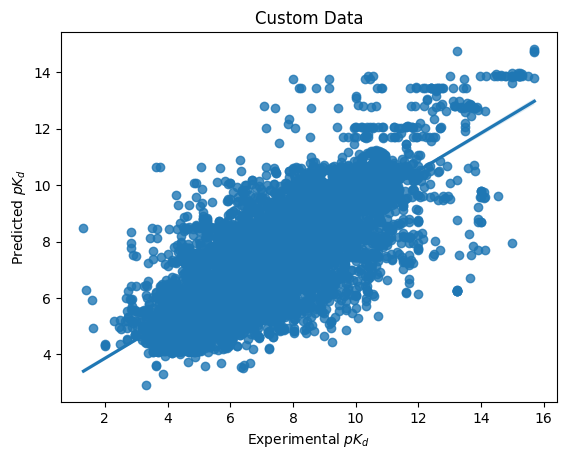

In [39]:
import seaborn as sns
from balm.metrics import get_ci, get_pearson, get_rmse, get_spearman

rmse = get_rmse(torch.tensor(labels), torch.tensor(predictions))
pearson = get_pearson(torch.tensor(labels), torch.tensor(predictions))
spearman = get_spearman(torch.tensor(labels), torch.tensor(predictions))
ci = get_ci(torch.tensor(labels), torch.tensor(predictions))

print(f"RMSE: {rmse}")
print(f"Pearson: {pearson}")
print(f"Spearman: {spearman}")
print(f"CI: {ci}")

# Log metrics to W&B
wandb.log({
    "RMSE": rmse.item(),
    "Pearson": pearson.item(),
    "Spearman": spearman.item(),
    "CI": ci.item()
})

ax = sns.regplot(x=labels, y=predictions)
ax.set_title(f"Custom Data")
ax.set_xlabel(r"Experimental $pK_d$")
ax.set_ylabel(r"Predicted $pK_d$")

# Save the plot
plt.savefig("regression_plot.png")

# Log the plot to W&B
wandb.log({"regression_plot": wandb.Image("regression_plot.png")})

# Optionally show the plot
plt.show()